# Relation Ranking Yu et al. 2017 Model

Our goal here to to reimplement Yu et al. 2017 93% relation model. 

First things first, set up the initial configuration.

In [1]:
import sys
sys.path.insert(0, '../../')

In [2]:
from tqdm import tqdm_notebook
from functools import partial
tqdm_notebook = partial(tqdm_notebook, leave=False)
tqdm_notebook().pandas()

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [3]:
import logging

from lib.utils import config_logging
from lib.utils import new_experiment_folder
from lib.utils import seed
from lib.utils import save_standard_streams
from lib.utils import device_default

experiment_folder = new_experiment_folder(label='relation_ranking', parent_directory='../../experiments/')
print('Experiment Folder: %s' % experiment_folder)
save_standard_streams(experiment_folder) # Copy Stdout and Stderr to experiments folder

config_logging()
logger = logging.getLogger(__name__)

device = device_default()
logger.info('Device: %d', device)
is_cuda = device >= 0
cuda = lambda t: t.cuda(device=device) if is_cuda else t

random_seed = 1212212
seed(random_seed, is_cuda=is_cuda)

# Async minibatch allocation for speed
# Reference: http://timdettmers.com/2015/03/09/deep-learning-hardware-guide/
cuda_async = lambda t: t.cuda(device=device, async=True) if is_cuda else t

Experiment Folder: ../../experiments/relation_ranking.02_12_15:12:45
[2018-02-12 15:12:45,779][MainProcess][__main__][INFO] Device: 0
[2018-02-12 15:12:45,780][MainProcess][lib.utils][INFO] Seed: 1212212


## Dataset

Load our dataset. Log a couple rows.

In [4]:
import os
from tqdm import tqdm_notebook

from lib.datasets.dataset import Dataset

def yu_dataset(directory='../../data/yu/',
               train=False,
               dev=False,
               test=False,
               train_filename='train.replace_ne.withpool',
               dev_filename='valid.replace_ne.withpool',
               test_filename='test.replace_ne.withpool',
               vocab_filename='relation.2M.list'):
    """
    Example line example: 40	61 40 117	which genre of album is #head_entity# ?
    Vocab example: /film/film/genre
    
    Sample Data:
        Question: 'which genre of album is #head_entity# ?'
        True Relation: '/music/album/genre'
        False Relation Pool: ['/music/album/release_type', '/music/album/genre', '/music/album/artist']
    """
    vocab_path = os.path.join(directory, vocab_filename)
    vocab = [l.strip() for l in open(vocab_path, 'r')]
    
    ret = []
    datasets = [(train, train_filename), (dev, dev_filename), (test, test_filename)]
    for is_requested, filename in datasets:
        if not is_requested:
            continue
            
        file_path = os.path.join(directory, filename)
        data = pd.read_table(file_path, header=None, names=['True Relation', 'Relation Pool', 'Question'])
        rows = []
        for i, row in tqdm_notebook(data.iterrows(), total=data.shape[0]):
            if row['Relation Pool'].strip() == 'noNegativeAnswer':
                continue
            relation_pool = [vocab[int(i) - 1].strip('/') for i in row['Relation Pool'].split()]
            true_relation = vocab[int(row['True Relation']) - 1].strip('/')
            question = row['Question'].strip()
            # Development and test set may or may not have the True relation based on our predicted pool
            if filename == train_filename:
                assert true_relation not in relation_pool
                
            rows.append({
                'Question': question,
                'Relation Pool': relation_pool,
                'Relation': true_relation
            })
        ret.append(Dataset(rows))

    if len(ret) == 1:
        return ret[0]
    else:
        return tuple(ret)

In [5]:
import os
from tqdm import tqdm_notebook

from lib.datasets.dataset import Dataset

def relation_ranking_dataset(directory='../../data/relation_ranking/',
               train=False,
               dev=False,
               test=False,
               train_filename='train.txt',
               dev_filename='dev.txt',
               test_filename=''):
    """
    Example line example: 
        film/film/country	film/film/country film/film/genre film/film/language	what country is <e> from ?
    Vocab example: 
        /film/film/genre
    
    Sample Data:
        Question: 'which genre of album is #head_entity# ?'
        True Relation: '/music/album/genre'
        False Relation Pool: ['/music/album/release_type', '/music/album/genre', '/music/album/artist']
    """
    ret = []
    datasets = [(train, train_filename), (dev, dev_filename), (test, test_filename)]
    for is_requested, filename in datasets:
        if not is_requested:
            continue
            
        file_path = os.path.join(directory, filename)
        data = pd.read_table(file_path, header=None, names=['True Relation', 'Relation Pool', 'Question', 'Entity'])
        rows = []
        for _, row in tqdm_notebook(data.iterrows(), total=data.shape[0]):
            relation_pool = set(row['Relation Pool'].split())
            relation = row['True Relation'].strip()
            
            # Nothing to back prop
            if filename == train_filename and relation not in relation_pool:
                continue
            
            # Nothing to back prop
            if filename == train_filename and len(relation_pool) == 1:
                continue
            
                
            rows.append({
                'Question': row['Question'].strip(),
                'Entity': row['Entity'].strip(),
                'Relation Pool': list(relation_pool),
                'Relation': relation
            })
        ret.append(Dataset(rows))

    if len(ret) == 1:
        return ret[0]
    else:
        return tuple(ret)

In [6]:
from IPython.display import display
import pandas as pd

train_dataset, dev_dataset = relation_ranking_dataset(train=True, dev=True)

print('Num Training Data: %d' % len(train_dataset))
print('Train Sample:')
display(pd.DataFrame(train_dataset[:5]))
print('\nNum Development Data: %d' % len(dev_dataset))
print('Development Sample:')
display(pd.DataFrame(dev_dataset[:5]))

HBox(children=(IntProgress(value=0, max=75729), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10816), HTML(value='')))


Num Training Data: 72694
Train Sample:


,Entity,Question,Relation,Relation Pool
0,e,what is the book <e> about,book/written_work/subjects,[user/mt/default_domain/metabolite/biofluid_lo...
1,cardiac arrest,to what release does the release track <e> com...,music/release_track/release,[medicine/icd_9_cm_classification/parent_class...
2,the debt,what country was the film <e> from,film/film/country,"[film/film/production_companies, film/film/pro..."
3,nobuo uematsu,what songs have <e> produced ?,music/producer/tracks_produced,"[music/composer/compositions, cvg/cvg_designer..."
4,eve - olution,who produced <e> ?,music/release/producers,"[music/album/genre, music/release/format, musi..."



Num Development Data: 10816
Development Sample:


,Entity,Question,Relation,Relation Pool
0,american,name an <e> thoroughbread racehorse,biology/organism_classification/organisms_of_t...,"[common/topic/image, dining/cuisine/ingredient..."
1,vision racing driving simulator,what kind of game is <e> ?,cvg/computer_videogame/cvg_genre,"[cvg/computer_videogame/gameplay_modes, cvg/co..."
2,romance film,what tv program is <e>,tv/tv_genre/programs,[base/skosbase/vocabulary_equivalent_topic/bro...
3,polaski,what state is <e> located in,location/location/containedby,[location/location/containedby]
4,fern emmett,what disease claimed the life of <e>,people/deceased_person/cause_of_death,"[people/deceased_person/cause_of_death, people..."


## Encode Text

Here we encode our data into a numerical format. 

In [7]:
from IPython.display import display
from tqdm import tqdm_notebook
import re

from lib.text_encoders import StaticTokenizerEncoder
from lib.text_encoders import DelimiterEncoder
from lib.text_encoders import WordEncoder

# We add development dataset to text_encoder for embeddings
# We make sure not to use the the development dataset to provide us with any vocab optimizations or learning
text_encoder = WordEncoder(train_dataset['Question'] + dev_dataset['Question'], lower=True, append_eos=False)
print('Text encoder vocab size: %d' % text_encoder.vocab_size)

relations = set(train_dataset['Relation'])
relation_word_encoder = StaticTokenizerEncoder(relations, tokenize=lambda s: re.split('/|_', s))
print('Relation word encoder vocab size: %d' % relation_word_encoder.vocab_size)

relation_encoder = DelimiterEncoder('/', relations)
print('Relation encoder vocab size: %d' % relation_encoder.vocab_size)
relations = None # Clear memory

for dataset in [train_dataset, dev_dataset]:
    for row in tqdm_notebook(dataset):
        row['Question'] = text_encoder.encode(row['Question'])
        if row['Relation'] in row['Relation Pool']:
            row['Relation Index'] = row['Relation Pool'].index(row['Relation'])
        else:
            row['Relation Index'] = None
        row['Relation Pool Word'] = [relation_word_encoder.encode(r) for r in row['Relation Pool']]
        row['Relation Pool'] = [relation_encoder.encode(r) for r in row['Relation Pool']]

print('Train Sample:')
display(pd.DataFrame(train_dataset[:5]))
print('Development Sample:')
display(pd.DataFrame(dev_dataset[:5]))

Text encoder vocab size: 6106
Relation word encoder vocab size: 1679
Relation encoder vocab size: 2201


HBox(children=(IntProgress(value=0, max=72694), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10816), HTML(value='')))


Train Sample:


,Entity,Question,Relation,Relation Index,Relation Pool,Relation Pool Word
0,e,"[4631, 4372, 4112, 474, 3626, 2585]",book/written_work/subjects,33,"[[1174, 135, 1335, 774, 1783], [237, 1, 1], [2...","[[937, 107, 1661, 773, 619, 785, 848], [194, 1..."
1,cardiac arrest,"[3342, 4631, 4270, 557, 4112, 4270, 4043, 3626...",music/release_track/release,51,"[[1136, 1200, 921], [614, 1702, 1195], [614, 1...","[[909, 1659, 258, 1642, 47, 376, 47], [484, 48..."
2,the debt,"[4631, 2386, 3572, 4112, 1769, 3626, 4062]",film/film/country,4,"[[422, 422, 352], [422, 422, 895], [422, 422, ...","[[352, 352, 995, 1541], [352, 352, 362, 685], ..."
3,nobuo uematsu,"[4631, 614, 1051, 3626, 1774, 716]",music/producer/tracks_produced,6,"[[237, 1382, 1138], [35, 390, 272], [237, 1116...","[[194, 1080, 911], [25, 25, 1561, 521, 1329], ..."
4,eve - olution,"[3059, 1774, 3626, 716]",music/release/producers,2,"[[237, 926, 1370], [237, 1790, 38], [237, 1790...","[[194, 730, 1076], [194, 1354, 26], [194, 1354..."


Development Sample:


,Entity,Question,Relation,Relation Index,Relation Pool,Relation Pool Word
0,american,"[1156, 1401, 3626, 1371, 303]",biology/organism_classification/organisms_of_t...,NaN,"[[933, 845, 1071], [641, 985, 284], [641, 985,...","[[734, 667, 857], [507, 771, 237], [507, 771, ..."
1,vision racing driving simulator,"[4631, 2685, 918, 2579, 4372, 3626, 716]",cvg/computer_videogame/cvg_genre,2.0,"[[35, 2052, 170], [35, 2052, 1014], [35, 2052,...","[[25, 88, 336, 1095, 682], [25, 88, 336, 796],..."
2,romance film,"[4631, 5076, 587, 4372, 3626]",tv/tv_genre/programs,4.0,"[[1156, 1843, 2081, 736], [465, 2095, 1629], [...","[[921, 1412, 395, 575, 667, 253, 864], [1305, ..."
3,polaski,"[4631, 917, 4372, 3626, 1594, 4449]",location/location/containedby,0.0,"[[1065, 1065, 62]]","[[848, 848, 44]]"
4,fern emmett,"[4631, 4586, 1447, 4112, 2008, 918, 3626]",people/deceased_person/cause_of_death,0.0,"[[1842, 443, 1699], [1842, 973, 781], [1842, 9...","[[1411, 1337, 761, 1603, 1051, 1298], [1411, 7..."


## Dataset Iterators

Define functions to create iterators over the development and the train dataset for each epoch.

In [8]:
import torch
from torch.autograd import Variable
from lib.utils import pad_batch

flatten = lambda l: [item for sublist in l for item in sublist]

# Defines how to combine a batch of rows into a tensor
def collate_fn(batch, train=True):
    """ list of tensors to a batch variable """
    # PyTorch RNN requires batches to be transposed for speed and integration with CUDA
    to_variable = (lambda b: Variable(torch.stack(b).t_().contiguous(), volatile=not train))
    
    
    relation_pool_lengths = [len(row['Relation Pool']) for row in batch]
    relation_pool_index = [row['Relation Index'] for row in batch]
    
    # TODO: Do not encode question multiple times...
    question_batch = flatten([[row['Question'] for _ in range(len(row['Relation Pool']))] for row in batch])
    question_batch, _ = pad_batch(question_batch)
    question_batch = to_variable(question_batch)
    
    relation_pool_word_batch = flatten([row['Relation Pool Word'] for row in batch])
    relation_pool_word_batch, _ = pad_batch(relation_pool_word_batch)
    relation_pool_word_batch = to_variable(relation_pool_word_batch)
    
    relation_pool_batch = flatten([row['Relation Pool'] for row in batch])
    relation_pool_batch, _ = pad_batch(relation_pool_batch)
    relation_pool_batch = to_variable(relation_pool_batch)
    

    return (question_batch, relation_pool_batch, relation_pool_word_batch,
            relation_pool_lengths, relation_pool_index)

In [9]:
from functools import partial
import random

from torch.utils.data import DataLoader

from lib.samplers import BucketBatchSampler
from lib.samplers import SortedSampler


from torch.utils.data.sampler import Sampler

# TODO: Better sizing function
sort_key = lambda r: r['Question'].size()[0]

class DynamicBucketBatchSampler(BucketBatchSampler):
    def __init__(self,
                 *args,
                 get_size=lambda _: 1,
                 **kwargs):
        # DynamicBucketBatchSampler does not assume a size of 1 for each item while batching it allows for a
        # custom size function.
        self.get_size = get_size
        super().__init__(*args, **kwargs)
    
    def _batchify(self):
        batch = []
        batch_size = 0
        for idx in self.sampler:
            sample_size = self.get_size(self.sampler.data_source[idx])
            batch_size += sample_size
            if batch_size > self.batch_size:
                yield batch
                batch = []
                batch_size = sample_size
            batch.append(idx)
        if len(batch) > 0 and not self.drop_last:
            yield batch

    def __iter__(self):
        batches = list(self._batchify())
        if self.last_batch_first:
            last_batch = batches.pop()
        if self.shuffle:
            random.shuffle(batches)
        if self.last_batch_first:
            batches.insert(0, last_batch)
        return iter(batches)
    
    def __len__(self):
        length = 0
        batch_size = 0
        for idx in self.sampler:
            sample_size = self.get_size(self.sampler.data_source[idx])
            batch_size += sample_size
            if batch_size > self.batch_size:
                length += 1
                batch_size = sample_size
        if batch_size > 0 and not self.drop_last:
            length += 1
        return length


def get_iterator(dataset, batch_size, train=False):
    # Use bucket sampling to group similar sized text but with noise + random
    batch_sampler = DynamicBucketBatchSampler(dataset, sort_key, batch_size, sort_key_noise=0.5,
                                              get_size=lambda r: len(r['Relation Pool']))
    return DataLoader(
        dataset,
        batch_sampler=batch_sampler,
        collate_fn=partial(collate_fn, train=train),
        pin_memory=is_cuda,
        num_workers=0)

# Model

Instantiate the model.

In [10]:
import torch
from lib.pretrained_embeddings import FastText

unk_init = lambda t: torch.FloatTensor(t).uniform_(-0.1, 0.1)
pretrained_embedding = FastText(language='en', cache='./../../.pretrained_embeddings_cache')
text_embedding_weights = torch.Tensor(text_encoder.vocab_size, pretrained_embedding.dim)
for i, token in enumerate(text_encoder.vocab):
    text_embedding_weights[i] = pretrained_embedding[token]
pretrained_embedding = None # Clear memory

[2018-02-12 15:13:08,298][MainProcess][lib.pretrained_embeddings][INFO] Loading vectors from ./../../.pretrained_embeddings_cache/wiki.en.vec.pt


In [11]:
import copy
from lib.nn import YuModel

def make_model(**kwargs):
    model = YuModel(relation_encoder.vocab_size, relation_word_encoder.vocab_size,
                    text_encoder.vocab_size, **kwargs)
    for param in model.parameters():
        param.data.uniform_(-0.1, 0.1)

    freeze_embeddings = True
    model.text_embedding.weight.data.copy_(text_embedding_weights)
    model.text_embedding.weight.requires_grad = not freeze_embeddings

    cuda(model)
    return model

## Evaluate

In [12]:
from collections import defaultdict 

def torch_chunk(tensor, chunk_sizes, dim=0):
    """Splits the tensor into chunks.

    ``tensor`` will be split into ``len(chunk_sizes)`` chunks with sizes in ``dim`` according
    to ``chunk_sizes``.

    Arguments:
        tensor (Tensor): tensor to split.
        chunk_sizes (list(int)): list of sizes for each chunk
        dim (int): dimension along which to split the tensor.
    """
    if dim < 0:
        dim += tensor.dim()
    dim_size = tensor.size(dim)

    if dim_size != sum(chunk_sizes):
        raise ValueError("Sum of split sizes exceeds tensor dim")
    split_indices = [0] + chunk_sizes
    split_indices = torch.cumsum(torch.Tensor(split_indices), dim=0)

    return tuple(
        tensor.narrow(int(dim), int(start), int(length)) if int(length) > 0 else None
        for start, length in zip(split_indices, chunk_sizes))

def evaluate(dataset, model, batch_size=1):
    model.train(mode=False)
    examples = defaultdict(list)
    iterator = get_iterator(dataset, batch_size)
    correct = 0
    for (question, relation_pool, relation_pool_word,
         pool_lengths, relation_pool_index) in tqdm_notebook(iterator, total=len(iterator)):
        
        output = model(cuda_async(question), cuda_async(relation_pool), cuda_async(relation_pool_word))
        output = output.data.cpu()
        chunks = torch_chunk(output, pool_lengths)
        for i, chunk in enumerate(chunks):
            predicted = torch.max(chunk, 0)[1][0]
            if predicted == relation_pool_index[i]:
                correct += 1

    model.train(True) # No side affects
    accuracy = correct / len(dataset)
    logger.info('Accuracy: %.03f', accuracy)
    return accuracy

## Hyperparameters

In [41]:
from lib.optim import Adam
from lib.configurable import configurable
from lib.configurable import add_config
from lib.configurable import log_config

Adam.__init__ = configurable(Adam.__init__)

add_config({
    'lib': {
        'nn.yu_model.YuModel.__init__': {
            'embedding_size': 300,
            'hidden_size': 300,
            'dropout_relation': 0.0,
            'dropout_text': 0.0,
            'n_layers_relation': 1
        },
        'optimizer.Optimizer.__init__.max_grad_norm': 1,
    },
    'lib.optim.adam.Adam.__init__': {
        'amsgrad': True
    }
})

log_config()

[2018-02-13 10:51:55,841][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 10:51:55,845][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 10:51:55,850][MainProcess][lib.configurable][INFO] Global configuration:
[2018-02-13 10:51:55,851][MainProcess][root][INFO] {   'lib': {   'nn': {   'yu_model': {   'YuModel': {   '__init__': {   'dropout_relation': 0.0,
                                                                        'dropout_text': 0.0,
                                                                        'embedding_size': 300,
                                                                        'hidden_size': 300,
                                                                        'n_layers_relation': 1}}}},
               'optim': {'adam': {'Adam': {'__init__': {'amsgrad': True}}}},
               'optimizer': {'Optimizer': {'__init__': {'max_grad_norm': 1}}}}}


## Training Loop

Below here, we do a training loop over a number of epochs.

In [42]:
from tqdm import tqdm_notebook
import random

from torch.utils.data import DataLoader
from torch.nn.modules.loss import MarginRankingLoss
from lib.optim import Adam
from functools import partial

from lib.checkpoint import Checkpoint
from lib.utils import get_total_parameters
from lib.utils import resplit_datasets
from lib.optimizer import Optimizer


if is_cuda:
    ByteTensor = torch.cuda.ByteTensor
    FloatTensor = torch.cuda.FloatTensor

def train(resources=30, checkpoint=None, margin=0.33, **kwargs):
    
    if isinstance(checkpoint, str):
        checkpoint = Checkpoint(checkpoint)
        model = checkpoint.model
        train_batch_size = checkpoint.train_batch_size
        optimizer = checkpoint.optimizer
        n_bad_epochs = checkpoint.n_bad_epochs
        max_score = checkpoint.max_score
    else:
        model = make_model()
        train_batch_size = 128
        # NOTE: https://github.com/pytorch/pytorch/issues/679
        params = filter(lambda p: p.requires_grad, model.parameters())
        optimizer = Optimizer(Adam(params=params))
        n_bad_epochs = 0
        max_score = 0

    # NOTE: Because the training dataset was used to train the subject recongition, its better; therefore,
    # we cannot mix them
    epochs = max(round(resources), 1)
    train_max_batch_size = 2048
    patience = 3
    criterion = cuda(MarginRankingLoss(margin=margin))
    logger.info('Epochs: %d', epochs)
    logger.info('Train Dataset Size: %d', len(train_dataset))
    logger.info('Dev Dataset Size: %d', len(dev_dataset))
    logger.info('Train Batch Size: %d', train_batch_size)
    logger.info('Train Max Batch Size: %d', train_max_batch_size)
    logger.info('Total Parameters: %d', get_total_parameters(model))
    logger.info('Model:\n%s' % model)
    
    # Train!
    for epoch in range(epochs):
        print('Epoch %d' % epoch)

        # Iterate over the training data
        model.train(mode=True)
        train_iterator = get_iterator(train_dataset, train_batch_size, True)
        for (question, relation_pool, relation_pool_word,
             pool_lengths, relation_pool_index) in tqdm_notebook(train_iterator):
            optimizer.zero_grad()
            output = model(cuda_async(question), cuda_async(relation_pool), cuda_async(relation_pool_word))
            
            loss = Variable(FloatTensor([0]))
            chunks = torch_chunk(output, pool_lengths)
            for true_index, chunk in zip(relation_pool_index, chunks):
                mask = ByteTensor(chunk.size()).fill_(1)
                mask[true_index] = 0
                false = chunk.masked_select(Variable(mask))
                true = chunk[true_index].expand(false.size())
                labels = Variable(FloatTensor(false.size()).fill_(1))
                loss += criterion(true, false, labels)

            # Backward propagation
            loss.backward()
            optimizer.step()

        # Save checkpoint
        checkpoint_path = Checkpoint.save(
            experiment_folder, {
                'model': model,
                'optimizer': optimizer,
                'relation_word_encoder': relation_word_encoder,
                'relation_encoder': relation_encoder,
                'text_encoder': text_encoder,
                'train_batch_size': train_batch_size,
                'n_bad_epochs': n_bad_epochs,
                'max_score': max_score
            },
            device=device)

        # Evaluate
        score = evaluate(dev_dataset, model, 4096)

        # Scheduler for increasing batch_size inspired by this paper:
        # https://openreview.net/forum?id=B1Yy1BxCZ
        if max_score > score:
            n_bad_epochs += 1
        else:
            n_bad_epochs = 0
            max_score = score

        if n_bad_epochs >= patience:
            train_batch_size = min(train_max_batch_size, train_batch_size * 2)
            logger.info('Ran out of patience, increasing train batch size to: %d', train_batch_size)
            
        print('–' * 100)
        
    return -max_score, checkpoint_path

In [43]:
train()

[2018-02-13 10:51:57,293][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.0,
    'dropout_text': 0.0,
    'embedding_size': 300,
    'hidden_size': 300,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-13 10:51:57,571][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdefe21a9b0>}
[2018-02-13 10:51:57,572][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdefe21a9b0>}
[2018-02-13 10:51:57,573][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{'max_grad_norm': 1, 'optim': <lib.optim.adam.Adam object at 0x7fdefe3280f0>}
[2018-02-13 10:51:57,573][MainProcess][__main__][INFO] Epochs: 30
[2018-02-13 10:51:57,574][MainProcess][__main__][INFO] Train Dataset

HBox(children=(IntProgress(value=0, max=12531), HTML(value='')))

Exception in thread Thread-874:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




[2018-02-13 10:55:35,996][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/70943.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 10:55:44,611][MainProcess][__main__][INFO] Accuracy: 0.866
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=12585), HTML(value='')))


[2018-02-13 10:59:23,630][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/71171.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 10:59:29,833][MainProcess][__main__][INFO] Accuracy: 0.871
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=12544), HTML(value='')))


[2018-02-13 11:03:20,842][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/71408.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 11:03:29,038][MainProcess][__main__][INFO] Accuracy: 0.878
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=12571), HTML(value='')))


[2018-02-13 11:07:29,400][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/71657.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 11:07:35,581][MainProcess][__main__][INFO] Accuracy: 0.879
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=12560), HTML(value='')))


[2018-02-13 11:20:57,675][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/72465.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 11:21:04,370][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=12539), HTML(value='')))


[2018-02-13 11:25:01,098][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/72709.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 11:25:08,381][MainProcess][__main__][INFO] Accuracy: 0.882
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=12556), HTML(value='')))


[2018-02-13 11:29:13,231][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/72961.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 11:29:20,757][MainProcess][__main__][INFO] Accuracy: 0.883
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 7


HBox(children=(IntProgress(value=0, max=12569), HTML(value='')))


[2018-02-13 11:33:09,271][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/73197.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 11:33:17,452][MainProcess][__main__][INFO] Accuracy: 0.881
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 8


HBox(children=(IntProgress(value=0, max=12548), HTML(value='')))


[2018-02-13 11:36:54,398][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/73422.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 11:37:00,692][MainProcess][__main__][INFO] Accuracy: 0.882
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 9


HBox(children=(IntProgress(value=0, max=12576), HTML(value='')))


[2018-02-13 11:40:58,585][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/73666.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 11:41:04,488][MainProcess][__main__][INFO] Accuracy: 0.881
[2018-02-13 11:41:04,491][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 256
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 10


HBox(children=(IntProgress(value=0, max=6053), HTML(value='')))


[2018-02-13 11:43:33,694][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/73821.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 11:43:39,847][MainProcess][__main__][INFO] Accuracy: 0.881
[2018-02-13 11:43:39,849][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 512
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 11


HBox(children=(IntProgress(value=0, max=2824), HTML(value='')))


[2018-02-13 11:45:54,751][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/73962.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 11:46:00,618][MainProcess][__main__][INFO] Accuracy: 0.882
[2018-02-13 11:46:00,620][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 1024
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 12


HBox(children=(IntProgress(value=0, max=1363), HTML(value='')))


[2018-02-13 11:48:10,665][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/74098.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 11:48:16,426][MainProcess][__main__][INFO] Accuracy: 0.881
[2018-02-13 11:48:16,429][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 2048
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 13


HBox(children=(IntProgress(value=0, max=672), HTML(value='')))


[2018-02-13 11:50:24,780][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/74232.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 11:50:31,155][MainProcess][__main__][INFO] Accuracy: 0.882
[2018-02-13 11:50:31,156][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 2048
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 14


HBox(children=(IntProgress(value=0, max=673), HTML(value='')))


[2018-02-13 11:52:40,705][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/74368.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 11:52:46,823][MainProcess][__main__][INFO] Accuracy: 0.882
[2018-02-13 11:52:46,825][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 2048
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 15


HBox(children=(IntProgress(value=0, max=672), HTML(value='')))


[2018-02-13 11:54:58,878][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/74506.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 11:55:04,982][MainProcess][__main__][INFO] Accuracy: 0.882
[2018-02-13 11:55:04,983][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 2048
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 16


HBox(children=(IntProgress(value=0, max=672), HTML(value='')))


[2018-02-13 11:57:27,166][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/74655.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 11:57:33,655][MainProcess][__main__][INFO] Accuracy: 0.881
[2018-02-13 11:57:33,657][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 2048
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 17


HBox(children=(IntProgress(value=0, max=672), HTML(value='')))


[2018-02-13 11:59:56,686][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/74804.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 12:00:02,767][MainProcess][__main__][INFO] Accuracy: 0.882
[2018-02-13 12:00:02,769][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 2048
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 18


HBox(children=(IntProgress(value=0, max=672), HTML(value='')))


[2018-02-13 12:02:14,198][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/74942.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 12:02:21,615][MainProcess][__main__][INFO] Accuracy: 0.882
[2018-02-13 12:02:21,618][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 2048
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 19


HBox(children=(IntProgress(value=0, max=672), HTML(value='')))


[2018-02-13 12:04:46,621][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/75094.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 12:04:53,407][MainProcess][__main__][INFO] Accuracy: 0.882
[2018-02-13 12:04:53,409][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 2048
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 20


HBox(children=(IntProgress(value=0, max=672), HTML(value='')))


[2018-02-13 12:07:10,408][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/75238.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 12:07:16,550][MainProcess][__main__][INFO] Accuracy: 0.880
[2018-02-13 12:07:16,553][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 2048
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 21


HBox(children=(IntProgress(value=0, max=671), HTML(value='')))


[2018-02-13 12:09:27,125][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/75375.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 12:09:32,864][MainProcess][__main__][INFO] Accuracy: 0.882
[2018-02-13 12:09:32,866][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 2048
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 22


HBox(children=(IntProgress(value=0, max=672), HTML(value='')))


[2018-02-13 12:11:43,558][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/75511.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 12:11:49,714][MainProcess][__main__][INFO] Accuracy: 0.879
[2018-02-13 12:11:49,717][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 2048
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 23


HBox(children=(IntProgress(value=0, max=672), HTML(value='')))

KeyboardInterrupt: 

## Hyperparameter Optimization

In [16]:
import torch
import random

from skopt.space import Real, Integer, Categorical

from lib.hyperparameter_optimization import hyperband
from lib.configurable import add_config
from lib.configurable import log_config

space  = [Real(0, 0.9, name='dropout_text'),
          Real(0, 0.9, name='dropout_relation'),
          Real(0.1, 1.9, name='margin'), # 1 == 90 degrees in consine distance
          Integer(50, 250, name='hidden_size'), # We multiply this hyperparameter by two to allow for bidirectional
          Real(0, 5, name='max_grad_norm')]

def objective(hidden_size, dropout_relation, dropout_text, max_grad_norm, margin, 
              *args, **kwargs):

    add_config({
        'lib': {
            'nn.yu_model.YuModel.__init__': {
                'embedding_size': 300,
                'hidden_size': int(hidden_size * 2),
                'dropout_relation': float(dropout_relation),
                'dropout_text': float(dropout_text),
                'n_layers_relation': 1
            },
            'optimizer.Optimizer.__init__.max_grad_norm': max_grad_norm,
        },
        'lib.optim.adam.Adam.__init__': {
            'amsgrad': True
        }
    })

    ret = train(margin=margin, *args, **kwargs)
    print('=' * 100)
    torch.cuda.empty_cache()
    return ret

scores, hyperparameters = hyperband(objective, space, max_resources_per_model=10, total_resources=400)
print('Best Accuracy: %.4f' % min(scores))

  0%|          | 0/400.0 [00:00<?, ?it/s]

[2018-02-12 15:13:12,493][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 15:13:12,494][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 15:13:12,495][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.4354824171118058,
    'dropout_text': 0.6541523676815214,
    'embedding_size': 300,
    'hidden_size': 364,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 15:13:15,210][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfed3b84a8>}
[2018-02-12 15:13:15,212][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 4.0723762456459944,
    'optim': <lib.optim.adam.Adam object at 0x7fdfed3b85f8>}
[2018-02-12 15:13:15,214][MainProcess][__main__][INFO] Epochs: 1
[2018-

HBox(children=(IntProgress(value=0, max=6030), HTML(value='')))


[2018-02-12 15:16:10,653][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/178.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 15:16:17,815][MainProcess][__main__][INFO] Accuracy: 0.813


  0%|          | 1.1111111111111112/400.0 [03:05<18:29:16, 166.86s/it, min_score=-0.813, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 15:16:17,892][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 15:16:17,893][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 15:16:17,894][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.6959389465108139,
    'dropout_text': 0.8881249556626121,
    'embedding_size': 300,
    'hidden_size': 114,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 15:16:18,156][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb5b07be0>}
[2018-02-12 15:16:18,158][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 4.7246358546551015,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6045), HTML(value='')))


[2018-02-12 15:18:16,674][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/304.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 15:18:20,289][MainProcess][__main__][INFO] Accuracy: 0.753


  1%|          | 2.2222222222222223/400.0 [05:07<16:33:29, 149.86s/it, min_score=-0.813, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 15:18:20,323][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 15:18:20,324][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 15:18:20,325][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.7995340880213163,
    'dropout_text': 0.5823973066174163,
    'embedding_size': 300,
    'hidden_size': 474,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 15:18:20,714][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fe080688e80>}
[2018-02-12 15:18:20,715][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 4.2456101141531271,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6048), HTML(value='')))


[2018-02-12 15:22:04,080][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/532.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 15:22:14,456][MainProcess][__main__][INFO] Accuracy: 0.776


  1%|          | 3.3333333333333335/400.0 [09:01<18:31:29, 168.13s/it, min_score=-0.813, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 15:22:14,493][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 15:22:14,495][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 15:22:14,496][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.5647493026730632,
    'dropout_text': 0.1516132320111015,
    'embedding_size': 300,
    'hidden_size': 482,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 15:22:14,886][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fe0894106a0>}
[2018-02-12 15:22:14,887][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 1.8385189692215618,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6042), HTML(value='')))


[2018-02-12 15:26:06,218][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/774.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 15:26:16,251][MainProcess][__main__][INFO] Accuracy: 0.741


  1%|          | 4.444444444444445/400.0 [13:03<20:06:16, 182.97s/it, min_score=-0.813, models_evaluated=0] 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 15:26:16,293][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 15:26:16,294][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 15:26:16,296][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.06424503266787153,
    'dropout_text': 0.5630522803212707,
    'embedding_size': 300,
    'hidden_size': 164,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 15:26:16,557][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfed3b8400>}
[2018-02-12 15:26:16,558][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 1.3717485044485931,
    'optim': <lib.optim.adam.A

HBox(children=(IntProgress(value=0, max=6026), HTML(value='')))


[2018-02-12 15:28:18,265][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/906.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 15:28:22,502][MainProcess][__main__][INFO] Accuracy: 0.694


  1%|▏         | 5.555555555555555/400.0 [15:10<17:46:06, 162.17s/it, min_score=-0.813, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 15:28:22,543][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 15:28:22,544][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 15:28:22,545][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.6763598372147798,
    'dropout_text': 0.169168368291481,
    'embedding_size': 300,
    'hidden_size': 368,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 15:28:22,879][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfed4583c8>}
[2018-02-12 15:28:22,880][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 0.60012494450016896,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6050), HTML(value='')))


[2018-02-12 15:31:29,174][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/1097.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 15:31:37,030][MainProcess][__main__][INFO] Accuracy: 0.757


  2%|▏         | 6.666666666666666/400.0 [18:24<18:08:33, 166.05s/it, min_score=-0.813, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 15:31:37,109][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 15:31:37,111][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 15:31:37,112][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.02808997650681148,
    'dropout_text': 0.8137662897921621,
    'embedding_size': 300,
    'hidden_size': 464,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 15:31:37,513][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb5b07f60>}
[2018-02-12 15:31:37,514][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 3.9923036381589907,
    'optim': <lib.optim.adam.A

HBox(children=(IntProgress(value=0, max=6040), HTML(value='')))


[2018-02-12 15:35:13,831][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/1321.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 15:35:22,765][MainProcess][__main__][INFO] Accuracy: 0.764


  2%|▏         | 7.777777777777777/400.0 [22:10<19:18:12, 177.18s/it, min_score=-0.813, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 15:35:22,813][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 15:35:22,814][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 15:35:22,815][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.291853170540437,
    'dropout_text': 0.27368433408356474,
    'embedding_size': 300,
    'hidden_size': 226,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 15:35:23,093][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb4fb8390>}
[2018-02-12 15:35:23,094][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 0.14523164317382933,
    'optim': <lib.optim.adam.A

HBox(children=(IntProgress(value=0, max=6035), HTML(value='')))


[2018-02-12 15:37:30,933][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/1458.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 15:37:35,785][MainProcess][__main__][INFO] Accuracy: 0.844


  2%|▏         | 8.888888888888888/400.0 [24:23<17:22:35, 159.94s/it, min_score=-0.844, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 15:37:35,847][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 15:37:35,848][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 15:37:35,849][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.5642004405638777,
    'dropout_text': 0.1756702751137407,
    'embedding_size': 300,
    'hidden_size': 356,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 15:37:36,172][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf3917dcc0>}
[2018-02-12 15:37:36,173][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 3.0045650263342076,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6038), HTML(value='')))


[2018-02-12 15:40:19,399][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/1627.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 15:40:26,317][MainProcess][__main__][INFO] Accuracy: 0.856


  2%|▏         | 9.999999999999998/400.0 [27:13<17:07:02, 158.01s/it, min_score=-0.856, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 15:40:26,390][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 15:40:26,391][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 15:40:26,392][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.6441316866187179,
    'dropout_text': 0.39702996629200427,
    'embedding_size': 300,
    'hidden_size': 234,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 15:40:26,674][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb5b07be0>}
[2018-02-12 15:40:26,675][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 2.3488326644570701,
    'optim': <lib.optim.adam.A

HBox(children=(IntProgress(value=0, max=6034), HTML(value='')))


[2018-02-12 15:42:35,283][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/1763.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 15:42:39,947][MainProcess][__main__][INFO] Accuracy: 0.722


  3%|▎         | 11.111111111111109/400.0 [29:27<15:50:42, 146.68s/it, min_score=-0.856, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 15:42:40,006][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 15:42:40,007][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 15:42:40,008][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.1491945765465774,
    'dropout_text': 0.059588065025676935,
    'embedding_size': 300,
    'hidden_size': 222,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 15:42:40,281][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb4fb8160>}
[2018-02-12 15:42:40,282][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 3.8298540476111778,
    'optim': <lib.optim.adam.

HBox(children=(IntProgress(value=0, max=6057), HTML(value='')))


[2018-02-12 15:44:46,410][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/1894.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 15:44:51,089][MainProcess][__main__][INFO] Accuracy: 0.846


  3%|▎         | 12.22222222222222/400.0 [31:38<14:52:25, 138.08s/it, min_score=-0.856, models_evaluated=0] 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 15:44:51,143][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 15:44:51,145][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 15:44:51,145][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.8119300461088904,
    'dropout_text': 0.21509059403566883,
    'embedding_size': 300,
    'hidden_size': 198,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 15:44:51,412][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb5fbc5f8>}
[2018-02-12 15:44:51,413][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 3.1377837319926987,
    'optim': <lib.optim.adam.A

HBox(children=(IntProgress(value=0, max=6055), HTML(value='')))


[2018-02-12 15:46:54,967][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/2022.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 15:46:59,457][MainProcess][__main__][INFO] Accuracy: 0.786


  3%|▎         | 13.33333333333333/400.0 [33:47<14:06:15, 131.31s/it, min_score=-0.856, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 15:46:59,499][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 15:46:59,501][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 15:46:59,501][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.8471681316998874,
    'dropout_text': 0.19646003819039606,
    'embedding_size': 300,
    'hidden_size': 274,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 15:46:59,790][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf3917dcc0>}
[2018-02-12 15:46:59,791][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 2.8687334370502913,
    'optim': <lib.optim.adam.A

HBox(children=(IntProgress(value=0, max=6054), HTML(value='')))


[2018-02-12 15:49:19,780][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/2167.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 15:49:25,414][MainProcess][__main__][INFO] Accuracy: 0.859


  4%|▎         | 14.444444444444441/400.0 [36:12<14:03:57, 131.34s/it, min_score=-0.859, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 15:49:25,489][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 15:49:25,490][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 15:49:25,491][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.04387871708213546,
    'dropout_text': 0.17879476569681713,
    'embedding_size': 300,
    'hidden_size': 434,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 15:49:25,849][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fe0806f42e8>}
[2018-02-12 15:49:25,850][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 3.9442037332966629,
    'optim': <lib.optim.adam.

HBox(children=(IntProgress(value=0, max=6053), HTML(value='')))


[2018-02-12 15:52:44,722][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/2372.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 15:52:53,091][MainProcess][__main__][INFO] Accuracy: 0.775


  4%|▍         | 15.555555555555552/400.0 [39:40<15:48:17, 148.00s/it, min_score=-0.859, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 15:52:53,128][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 15:52:53,130][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 15:52:53,130][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.27680702377349686,
    'dropout_text': 0.8041510876297386,
    'embedding_size': 300,
    'hidden_size': 222,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 15:52:53,405][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fe0806f42e8>}
[2018-02-12 15:52:53,406][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 0.2676460292301181,
    'optim': <lib.optim.adam.A

HBox(children=(IntProgress(value=0, max=6059), HTML(value='')))


[2018-02-12 15:55:00,417][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/2508.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 15:55:05,107][MainProcess][__main__][INFO] Accuracy: 0.832


  4%|▍         | 16.666666666666664/400.0 [41:52<14:49:37, 139.24s/it, min_score=-0.859, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 15:55:05,149][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 15:55:05,150][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 15:55:05,151][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.30630397922052155,
    'dropout_text': 0.507879474699856,
    'embedding_size': 300,
    'hidden_size': 172,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 15:55:05,409][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb5b07f28>}
[2018-02-12 15:55:05,410][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 3.6523961063109227,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6042), HTML(value='')))


[2018-02-12 15:57:00,455][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/2628.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 15:57:04,568][MainProcess][__main__][INFO] Accuracy: 0.843


  4%|▍         | 17.777777777777775/400.0 [43:52<13:46:27, 129.74s/it, min_score=-0.859, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 15:57:04,647][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 15:57:04,648][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 15:57:04,649][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.5963119437134142,
    'dropout_text': 0.4272229963179085,
    'embedding_size': 300,
    'hidden_size': 412,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 15:57:04,995][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fe0894106a0>}
[2018-02-12 15:57:04,996][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 3.0895216156403116,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6064), HTML(value='')))


[2018-02-12 16:00:10,752][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/2818.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 16:00:18,475][MainProcess][__main__][INFO] Accuracy: 0.852


  5%|▍         | 18.888888888888886/400.0 [47:06<15:09:19, 143.16s/it, min_score=-0.859, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 16:00:18,512][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 16:00:18,513][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 16:00:18,513][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.34226445737202277,
    'dropout_text': 0.5487202209166747,
    'embedding_size': 300,
    'hidden_size': 492,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 16:00:18,902][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb5aa4f28>}
[2018-02-12 16:00:18,903][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 0.26952131978216615,
    'optim': <lib.optim.adam.

HBox(children=(IntProgress(value=0, max=6045), HTML(value='')))


[2018-02-12 16:04:01,080][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/3049.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 16:04:10,926][MainProcess][__main__][INFO] Accuracy: 0.843


  5%|▍         | 19.999999999999996/400.0 [50:58<17:12:10, 162.97s/it, min_score=-0.859, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 16:04:10,969][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 16:04:10,970][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 16:04:10,971][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.3425501505965652,
    'dropout_text': 0.857944216502399,
    'embedding_size': 300,
    'hidden_size': 300,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 16:04:11,269][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb5aa4080>}
[2018-02-12 16:04:11,270][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 3.0262635203987474,
    'optim': <lib.optim.adam.Ada

HBox(children=(IntProgress(value=0, max=6060), HTML(value='')))


[2018-02-12 16:06:36,087][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/3204.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 16:06:41,958][MainProcess][__main__][INFO] Accuracy: 0.778


  5%|▌         | 21.111111111111107/400.0 [53:29<16:17:57, 154.87s/it, min_score=-0.859, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 16:06:42,027][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 16:06:42,028][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 16:06:42,029][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.5150209967473012,
    'dropout_text': 0.4358243543539775,
    'embedding_size': 300,
    'hidden_size': 166,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 16:06:42,287][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf39033d30>}
[2018-02-12 16:06:42,288][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 4.5511702746807838,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6053), HTML(value='')))


[2018-02-12 16:08:40,417][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/3328.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 16:08:44,227][MainProcess][__main__][INFO] Accuracy: 0.837


  6%|▌         | 22.222222222222218/400.0 [55:31<14:50:26, 141.42s/it, min_score=-0.859, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 16:08:44,302][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 16:08:44,303][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 16:08:44,304][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.732077720196688,
    'dropout_text': 0.5081425705324497,
    'embedding_size': 300,
    'hidden_size': 362,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 16:08:44,630][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf39033a20>}
[2018-02-12 16:08:44,631][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 4.8250860415844059,
    'optim': <lib.optim.adam.Ada

HBox(children=(IntProgress(value=0, max=6052), HTML(value='')))


[2018-02-12 16:11:32,119][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/3500.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 16:11:39,416][MainProcess][__main__][INFO] Accuracy: 0.863


  6%|▌         | 23.33333333333333/400.0 [58:26<15:18:21, 146.29s/it, min_score=-0.863, models_evaluated=0] 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 16:11:39,456][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 16:11:39,458][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 16:11:39,459][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.34942570682552604,
    'dropout_text': 0.08669646944493775,
    'embedding_size': 300,
    'hidden_size': 168,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 16:11:39,718][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb2f7fe10>}
[2018-02-12 16:11:39,719][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 3.55843739978146,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6052), HTML(value='')))


[2018-02-12 16:13:34,757][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/3622.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 16:13:38,796][MainProcess][__main__][INFO] Accuracy: 0.830


  6%|▌         | 24.44444444444444/400.0 [1:00:26<14:02:40, 134.63s/it, min_score=-0.863, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 16:13:38,822][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 16:13:38,823][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 16:13:38,824][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.8683504757656205,
    'dropout_text': 0.2001428287128299,
    'embedding_size': 300,
    'hidden_size': 204,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 16:13:39,093][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb4fb8128>}
[2018-02-12 16:13:39,094][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 3.658022948165724,
    'optim': <lib.optim.adam.Ada

HBox(children=(IntProgress(value=0, max=6043), HTML(value='')))


[2018-02-12 16:15:38,682][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/3746.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 16:15:42,902][MainProcess][__main__][INFO] Accuracy: 0.772


  6%|▋         | 25.55555555555555/400.0 [1:02:30<13:17:20, 127.76s/it, min_score=-0.863, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 16:15:42,983][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 16:15:42,984][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 16:15:42,985][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.8700152282881105,
    'dropout_text': 0.7436051913374693,
    'embedding_size': 300,
    'hidden_size': 362,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 16:15:43,309][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb5b07f60>}
[2018-02-12 16:15:43,310][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 2.793847577711031,
    'optim': <lib.optim.adam.Ada

HBox(children=(IntProgress(value=0, max=6033), HTML(value='')))


[2018-02-12 16:18:33,432][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/3921.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 16:18:40,360][MainProcess][__main__][INFO] Accuracy: 0.794


  7%|▋         | 26.66666666666666/400.0 [1:05:27<14:14:33, 137.34s/it, min_score=-0.863, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 16:18:40,404][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 16:18:40,405][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 16:18:40,406][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.45941004315047423,
    'dropout_text': 0.06798913604662014,
    'embedding_size': 300,
    'hidden_size': 178,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 16:18:40,668][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb2f7f4a8>}
[2018-02-12 16:18:40,669][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 4.2484970200752681,
    'optim': <lib.optim.adam.

HBox(children=(IntProgress(value=0, max=6026), HTML(value='')))


[2018-02-12 16:20:40,441][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/4048.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 16:20:44,599][MainProcess][__main__][INFO] Accuracy: 0.821


  7%|▋         | 27.77777777777777/400.0 [1:07:32<13:24:33, 129.69s/it, min_score=-0.863, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 16:20:44,675][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 16:20:44,676][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 16:20:44,676][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.6540474110804803,
    'dropout_text': 0.1733373796722992,
    'embedding_size': 300,
    'hidden_size': 434,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 16:20:45,033][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fe055dfc160>}
[2018-02-12 16:20:45,034][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 4.2423063785780117,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6050), HTML(value='')))


[2018-02-12 16:24:03,038][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/4250.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 16:24:11,464][MainProcess][__main__][INFO] Accuracy: 0.805


  7%|▋         | 28.888888888888882/400.0 [1:10:59<15:06:57, 146.63s/it, min_score=-0.863, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 16:24:11,533][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 16:24:11,534][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 16:24:11,535][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.33004462828169884,
    'dropout_text': 0.5434028460267284,
    'embedding_size': 300,
    'hidden_size': 152,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 16:24:11,792][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf3914c4e0>}
[2018-02-12 16:24:11,794][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 3.2497873378246038,
    'optim': <lib.optim.adam.A

HBox(children=(IntProgress(value=0, max=6022), HTML(value='')))


[2018-02-12 16:26:05,945][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/4373.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 16:26:09,522][MainProcess][__main__][INFO] Accuracy: 0.869


  7%|▋         | 29.999999999999993/400.0 [1:12:57<13:49:29, 134.51s/it, min_score=-0.869, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 16:26:09,560][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 16:26:09,561][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 16:26:09,562][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.03262116658644512,
    'dropout_text': 0.39524054118969826,
    'embedding_size': 300,
    'hidden_size': 456,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 16:26:09,928][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfed458358>}
[2018-02-12 16:26:09,929][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 3.3324218594616046,
    'optim': <lib.optim.adam.

HBox(children=(IntProgress(value=0, max=6049), HTML(value='')))


[2018-02-12 16:29:38,257][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/4586.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 16:29:47,302][MainProcess][__main__][INFO] Accuracy: 0.656


  8%|▊         | 31.111111111111104/400.0 [1:16:34<15:40:24, 152.96s/it, min_score=-0.869, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 16:29:47,341][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 16:29:47,342][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 16:29:47,342][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.882687559681397,
    'dropout_text': 0.5716657366603334,
    'embedding_size': 300,
    'hidden_size': 284,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 16:29:47,639][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfed3b8400>}
[2018-02-12 16:29:47,640][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 1.0369911779421539,
    'optim': <lib.optim.adam.Ada

HBox(children=(IntProgress(value=0, max=6047), HTML(value='')))


[2018-02-12 16:32:06,519][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/4734.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 16:32:12,088][MainProcess][__main__][INFO] Accuracy: 0.863


  8%|▊         | 32.222222222222214/400.0 [1:18:59<14:55:59, 146.17s/it, min_score=-0.869, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 16:32:12,160][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 16:32:12,162][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 16:32:12,164][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.5049583615444668,
    'dropout_text': 0.4676166029862506,
    'embedding_size': 300,
    'hidden_size': 240,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 16:32:12,445][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb5b07f60>}
[2018-02-12 16:32:12,446][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 3.4487781162046045,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6048), HTML(value='')))


[2018-02-12 16:34:17,966][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/4865.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 16:34:22,587][MainProcess][__main__][INFO] Accuracy: 0.822


  8%|▊         | 33.33333333333333/400.0 [1:21:10<14:00:35, 137.55s/it, min_score=-0.869, models_evaluated=0] 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 16:34:22,642][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 16:34:22,643][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 16:34:22,644][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.11896459087034525,
    'dropout_text': 0.839576582493105,
    'embedding_size': 300,
    'hidden_size': 284,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 16:34:22,937][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf3902c320>}
[2018-02-12 16:34:22,938][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 4.1044787240747853,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6053), HTML(value='')))


[2018-02-12 16:36:42,559][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/5010.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 16:36:48,155][MainProcess][__main__][INFO] Accuracy: 0.678


  9%|▊         | 34.44444444444444/400.0 [1:23:35<13:46:03, 135.59s/it, min_score=-0.869, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 16:36:48,196][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 16:36:48,197][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 16:36:48,198][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.6696357880250865,
    'dropout_text': 0.8046169920070204,
    'embedding_size': 300,
    'hidden_size': 242,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 16:36:48,479][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf39033358>}
[2018-02-12 16:36:48,480][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 0.46655819826747885,
    'optim': <lib.optim.adam.A

HBox(children=(IntProgress(value=0, max=6054), HTML(value='')))


[2018-02-12 16:39:00,155][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/5148.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 16:39:05,130][MainProcess][__main__][INFO] Accuracy: 0.830


  9%|▉         | 35.55555555555556/400.0 [1:25:52<13:21:08, 131.90s/it, min_score=-0.869, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 16:39:05,184][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 16:39:05,185][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 16:39:05,187][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.8167282997841345,
    'dropout_text': 0.25298867273697245,
    'embedding_size': 300,
    'hidden_size': 290,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 16:39:05,484][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb4fdd208>}
[2018-02-12 16:39:05,485][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 0.6549643136539347,
    'optim': <lib.optim.adam.A

HBox(children=(IntProgress(value=0, max=6055), HTML(value='')))


[2018-02-12 16:41:31,552][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/5299.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 16:41:37,178][MainProcess][__main__][INFO] Accuracy: 0.853


  9%|▉         | 36.66666666666667/400.0 [1:28:24<13:27:42, 133.38s/it, min_score=-0.869, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 16:41:37,239][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 16:41:37,240][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 16:41:37,240][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.6534962060468067,
    'dropout_text': 0.5702203731018106,
    'embedding_size': 300,
    'hidden_size': 184,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 16:41:37,503][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf3906dc18>}
[2018-02-12 16:41:37,504][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 2.5206963313474402,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6040), HTML(value='')))


[2018-02-12 16:43:34,316][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/5422.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 16:43:38,241][MainProcess][__main__][INFO] Accuracy: 0.761


  9%|▉         | 37.777777777777786/400.0 [1:30:25<12:40:58, 126.05s/it, min_score=-0.869, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 16:43:38,287][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 16:43:38,288][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 16:43:38,289][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.8116468767290282,
    'dropout_text': 0.38474516190361285,
    'embedding_size': 300,
    'hidden_size': 320,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 16:43:38,597][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb22b4588>}
[2018-02-12 16:43:38,598][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 2.8849119361230251,
    'optim': <lib.optim.adam.A

HBox(children=(IntProgress(value=0, max=6037), HTML(value='')))


[2018-02-12 16:46:04,147][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/5572.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 16:46:10,150][MainProcess][__main__][INFO] Accuracy: 0.865


 10%|▉         | 38.8888888888889/400.0 [1:32:57<12:57:54, 129.25s/it, min_score=-0.869, models_evaluated=0]  

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 16:46:10,200][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 16:46:10,201][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 16:46:10,202][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.5573328074072691,
    'dropout_text': 0.03530385441598623,
    'embedding_size': 300,
    'hidden_size': 300,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 16:46:10,502][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fe055dfc128>}
[2018-02-12 16:46:10,503][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 0.16701511423063034,
    'optim': <lib.optim.adam.

HBox(children=(IntProgress(value=0, max=6050), HTML(value='')))


[2018-02-12 16:48:36,510][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/5724.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 16:48:42,393][MainProcess][__main__][INFO] Accuracy: 0.739


 10%|█         | 40.000000000000014/400.0 [1:35:29<13:09:33, 131.59s/it, min_score=-0.869, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 16:48:42,486][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 16:48:42,487][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 16:48:42,488][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.28557566979884746,
    'dropout_text': 0.2353655324057127,
    'embedding_size': 300,
    'hidden_size': 300,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 16:48:42,788][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fe0806f42e8>}
[2018-02-12 16:48:42,789][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 4.6469233353624384,
    'optim': <lib.optim.adam.A

HBox(children=(IntProgress(value=0, max=6027), HTML(value='')))


[2018-02-12 16:51:06,446][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/5874.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 16:51:12,012][MainProcess][__main__][INFO] Accuracy: 0.863


 10%|█         | 41.11111111111113/400.0 [1:37:59<13:12:32, 132.50s/it, min_score=-0.869, models_evaluated=0] 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 16:51:12,059][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 16:51:12,060][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 16:51:12,061][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.7876963397889215,
    'dropout_text': 0.6379638735159207,
    'embedding_size': 300,
    'hidden_size': 204,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 16:51:12,332][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf3902ce48>}
[2018-02-12 16:51:12,333][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 3.5682327080830891,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6038), HTML(value='')))


[2018-02-12 16:53:12,500][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/6000.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 16:53:17,002][MainProcess][__main__][INFO] Accuracy: 0.729


 11%|█         | 42.22222222222224/400.0 [1:40:04<12:34:16, 126.49s/it, min_score=-0.869, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 16:53:17,034][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 16:53:17,035][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 16:53:17,036][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.2503785069702345,
    'dropout_text': 0.868982050545429,
    'embedding_size': 300,
    'hidden_size': 120,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 16:53:17,287][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf3902c6d8>}
[2018-02-12 16:53:17,289][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 1.4639982355615169,
    'optim': <lib.optim.adam.Ada

HBox(children=(IntProgress(value=0, max=6025), HTML(value='')))


[2018-02-12 16:55:12,491][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/6120.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 16:55:16,080][MainProcess][__main__][INFO] Accuracy: 0.809


 11%|█         | 43.33333333333336/400.0 [1:42:03<11:57:28, 120.70s/it, min_score=-0.869, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 16:55:16,110][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 16:55:16,111][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 16:55:16,112][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.6223386853781652,
    'dropout_text': 0.8438165490573475,
    'embedding_size': 300,
    'hidden_size': 180,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 16:55:16,374][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf34037588>}
[2018-02-12 16:55:16,375][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 4.0224414003408739,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6055), HTML(value='')))


[2018-02-12 16:57:12,714][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/6240.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 16:57:16,585][MainProcess][__main__][INFO] Accuracy: 0.861


 11%|█         | 44.44444444444447/400.0 [1:44:04<11:33:32, 117.04s/it, min_score=-0.869, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 16:57:16,661][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 16:57:16,662][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 16:57:16,663][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.34192820428417875,
    'dropout_text': 0.12005978301529358,
    'embedding_size': 300,
    'hidden_size': 402,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 16:57:17,003][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf3903dbe0>}
[2018-02-12 16:57:17,005][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 3.9527464679161337,
    'optim': <lib.optim.adam.

HBox(children=(IntProgress(value=0, max=6060), HTML(value='')))


[2018-02-12 17:00:26,466][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/6434.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 17:00:34,189][MainProcess][__main__][INFO] Accuracy: 0.707


 11%|█▏        | 45.555555555555586/400.0 [1:47:21<13:19:06, 135.27s/it, min_score=-0.869, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 17:00:34,244][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 17:00:34,245][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 17:00:34,246][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.8679891427035089,
    'dropout_text': 0.8762076887300941,
    'embedding_size': 300,
    'hidden_size': 338,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 17:00:34,565][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf39033208>}
[2018-02-12 17:00:34,566][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 3.196964267906929,
    'optim': <lib.optim.adam.Ada

HBox(children=(IntProgress(value=0, max=6031), HTML(value='')))


[2018-02-12 17:03:17,373][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/6605.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 17:03:24,179][MainProcess][__main__][INFO] Accuracy: 0.723


 12%|█▏        | 46.6666666666667/400.0 [1:50:11<13:47:52, 140.58s/it, min_score=-0.869, models_evaluated=0]  

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 17:03:24,217][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 17:03:24,218][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 17:03:24,220][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.3244446754143088,
    'dropout_text': 0.0843970241805853,
    'embedding_size': 300,
    'hidden_size': 328,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 17:03:24,535][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb2f7fb00>}
[2018-02-12 17:03:24,537][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 4.2949712374904596,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6028), HTML(value='')))


[2018-02-12 17:05:58,071][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/6766.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 17:06:04,488][MainProcess][__main__][INFO] Accuracy: 0.842


 12%|█▏        | 47.777777777777814/400.0 [1:52:52<13:51:45, 141.69s/it, min_score=-0.869, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 17:06:04,514][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 17:06:04,515][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 17:06:04,516][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.29535512594874447,
    'dropout_text': 0.6262219873094668,
    'embedding_size': 300,
    'hidden_size': 326,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 17:06:04,826][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf3914cf60>}
[2018-02-12 17:06:04,827][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 1.419805009594902,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6043), HTML(value='')))


[2018-02-12 17:08:42,719][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/6930.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 17:08:48,977][MainProcess][__main__][INFO] Accuracy: 0.853


 12%|█▏        | 48.88888888888893/400.0 [1:55:36<14:00:22, 143.61s/it, min_score=-0.869, models_evaluated=0] 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 17:08:49,054][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 17:08:49,055][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 17:08:49,056][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.820429652225009,
    'dropout_text': 0.8814767977385177,
    'embedding_size': 300,
    'hidden_size': 480,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 17:08:49,440][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf3914c4e0>}
[2018-02-12 17:08:49,441][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 2.6757740808398176,
    'optim': <lib.optim.adam.Ada

HBox(children=(IntProgress(value=0, max=6042), HTML(value='')))


[2018-02-12 17:12:19,044][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/7147.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 17:12:28,484][MainProcess][__main__][INFO] Accuracy: 0.865


 13%|█▎        | 50.00000000000004/400.0 [1:59:16<15:32:07, 159.79s/it, min_score=-0.869, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 17:12:28,558][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 17:12:28,559][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 17:12:28,560][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.6562658564844993,
    'dropout_text': 0.15231057311707152,
    'embedding_size': 300,
    'hidden_size': 326,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 17:12:28,871][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb2f94ba8>}
[2018-02-12 17:12:28,873][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 2.5607852351948774,
    'optim': <lib.optim.adam.A

HBox(children=(IntProgress(value=0, max=6044), HTML(value='')))


[2018-02-12 17:15:08,268][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/7316.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 17:15:14,996][MainProcess][__main__][INFO] Accuracy: 0.729


 13%|█▎        | 51.11111111111116/400.0 [2:02:02<15:11:46, 156.80s/it, min_score=-0.869, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 17:15:15,035][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 17:15:15,037][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 17:15:15,038][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.5497111609609516,
    'dropout_text': 0.39148752210426246,
    'embedding_size': 300,
    'hidden_size': 492,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 17:15:15,427][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf3903d0f0>}
[2018-02-12 17:15:15,428][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 3.3514795988482726,
    'optim': <lib.optim.adam.A

HBox(children=(IntProgress(value=0, max=6045), HTML(value='')))


[2018-02-12 17:18:59,629][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/7547.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 17:19:09,277][MainProcess][__main__][INFO] Accuracy: 0.748


 13%|█▎        | 52.22222222222227/400.0 [2:05:56<16:42:52, 173.02s/it, min_score=-0.869, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 17:19:09,324][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 17:19:09,325][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 17:19:09,326][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.8948684738265021,
    'dropout_text': 0.1270062506817584,
    'embedding_size': 300,
    'hidden_size': 460,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 17:19:09,700][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf3902c2b0>}
[2018-02-12 17:19:09,701][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 3.8007433236946055,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6029), HTML(value='')))


[2018-02-12 17:22:41,162][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/7769.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 17:22:50,310][MainProcess][__main__][INFO] Accuracy: 0.661


 13%|█▎        | 53.333333333333385/400.0 [2:09:37<17:24:34, 180.79s/it, min_score=-0.869, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 17:22:50,357][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 17:22:50,358][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 17:22:50,359][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.7125092050406051,
    'dropout_text': 0.5382156778661448,
    'embedding_size': 300,
    'hidden_size': 264,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 17:22:50,650][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb22b4d30>}
[2018-02-12 17:22:50,652][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 1.9990789537997053,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6033), HTML(value='')))


[2018-02-12 17:25:04,765][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/7912.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 17:25:10,188][MainProcess][__main__][INFO] Accuracy: 0.858


 14%|█▎        | 54.4444444444445/400.0 [2:11:57<15:46:26, 164.33s/it, min_score=-0.869, models_evaluated=0]  

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 17:25:10,281][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 17:25:10,282][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 17:25:10,283][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.7920170086812618,
    'dropout_text': 0.5247197898156789,
    'embedding_size': 300,
    'hidden_size': 454,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 17:25:10,658][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb1358160>}
[2018-02-12 17:25:10,659][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 4.7258833912596003,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6034), HTML(value='')))


[2018-02-12 17:28:41,936][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/8129.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 17:28:50,944][MainProcess][__main__][INFO] Accuracy: 0.731


 14%|█▍        | 55.555555555555614/400.0 [2:15:38<16:42:29, 174.63s/it, min_score=-0.869, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 17:28:50,998][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 17:28:50,999][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 17:28:51,000][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.5700744017372423,
    'dropout_text': 0.8979016954786319,
    'embedding_size': 300,
    'hidden_size': 498,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 17:28:51,392][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb22b4588>}
[2018-02-12 17:28:51,393][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 1.7030007067316242,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6062), HTML(value='')))


[2018-02-12 17:32:36,052][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/8364.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 17:32:45,937][MainProcess][__main__][INFO] Accuracy: 0.865


 14%|█▍        | 56.66666666666673/400.0 [2:19:33<17:42:32, 185.69s/it, min_score=-0.869, models_evaluated=0] 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 17:32:45,984][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 17:32:45,985][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 17:32:45,986][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.7322899544857179,
    'dropout_text': 0.5272884404417265,
    'embedding_size': 300,
    'hidden_size': 416,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 17:32:46,336][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fe055dfc128>}
[2018-02-12 17:32:46,337][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 0.92370374094565566,
    'optim': <lib.optim.adam.A

HBox(children=(IntProgress(value=0, max=6049), HTML(value='')))


[2018-02-12 17:35:51,313][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/8559.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 17:35:59,099][MainProcess][__main__][INFO] Accuracy: 0.865


 14%|█▍        | 57.77777777777784/400.0 [2:22:46<17:18:53, 182.14s/it, min_score=-0.869, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 17:35:59,177][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 17:35:59,178][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 17:35:59,179][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.1985652760370743,
    'dropout_text': 0.7374106029559295,
    'embedding_size': 300,
    'hidden_size': 280,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 17:35:59,472][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf3404ba90>}
[2018-02-12 17:35:59,473][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 0.29613095024610131,
    'optim': <lib.optim.adam.A

HBox(children=(IntProgress(value=0, max=6056), HTML(value='')))


[2018-02-12 17:38:18,443][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/8706.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 17:38:23,696][MainProcess][__main__][INFO] Accuracy: 0.812


 15%|█▍        | 58.88888888888896/400.0 [2:25:11<15:46:45, 166.53s/it, min_score=-0.869, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 17:38:23,734][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 17:38:23,735][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 17:38:23,736][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.830009629572915,
    'dropout_text': 0.049693141790477874,
    'embedding_size': 300,
    'hidden_size': 170,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 17:38:23,999][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfed3b8400>}
[2018-02-12 17:38:24,000][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 1.5122502935400248,
    'optim': <lib.optim.adam.A

HBox(children=(IntProgress(value=0, max=6033), HTML(value='')))


[2018-02-12 17:40:23,602][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/8831.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 17:40:27,469][MainProcess][__main__][INFO] Accuracy: 0.826


 15%|█▌        | 60.00000000000007/400.0 [2:27:15<14:09:58, 150.00s/it, min_score=-0.869, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 17:40:27,527][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 17:40:27,528][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 17:40:27,529][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.40048344590888874,
    'dropout_text': 0.5027956110132004,
    'embedding_size': 300,
    'hidden_size': 234,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 17:40:27,818][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfed3b8400>}
[2018-02-12 17:40:27,820][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 1.6643579646162268,
    'optim': <lib.optim.adam.A

HBox(children=(IntProgress(value=0, max=6041), HTML(value='')))


[2018-02-12 17:42:37,572][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/8965.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 17:42:42,521][MainProcess][__main__][INFO] Accuracy: 0.776


 15%|█▌        | 61.111111111111185/400.0 [2:29:30<13:18:59, 141.46s/it, min_score=-0.869, models_evaluated=0]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 17:42:42,580][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 17:42:42,582][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 17:42:42,582][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.6543761871757829,
    'dropout_text': 0.8834888002784833,
    'embedding_size': 300,
    'hidden_size': 342,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 17:42:42,898][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb2fa1b70>}
[2018-02-12 17:42:42,899][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 2.9013993249368739,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6046), HTML(value='')))


[2018-02-12 17:45:25,393][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/9133.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 17:45:32,166][MainProcess][__main__][INFO] Accuracy: 0.816


 16%|█▌        | 62.2222222222223/400.0 [2:32:19<13:35:16, 144.82s/it, min_score=-0.869, models_evaluated=0]  

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 17:45:32,194][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 17:45:32,195][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 17:45:32,196][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.5938071496141208,
    'dropout_text': 0.7269428232582466,
    'embedding_size': 300,
    'hidden_size': 428,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 17:45:32,561][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf3904e7f0>}
[2018-02-12 17:45:32,562][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 2.3094180897540855,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6058), HTML(value='')))


[2018-02-12 17:48:43,602][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/9331.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 17:48:51,609][MainProcess][__main__][INFO] Accuracy: 0.861


 16%|█▌        | 63.333333333333414/400.0 [2:35:39<14:31:01, 155.23s/it, min_score=-0.869, models_evaluated=38]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 17:48:51,678][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 17:48:51,679][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 17:48:51,680][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/4373.pt onto device 0
[2018-02-12 17:48:51,849][MainProcess][__main__][INFO] Epochs: 2
[2018-02-12 17:48:51,850][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-12 17:48:51,851][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-12 17:48:51,852][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-12 17:48:51,853][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-12 17:48:51,854][MainProcess][__main__][INFO] Total Parameters: 3377120
[2018-02-12 17:48:51,855][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embedd

HBox(children=(IntProgress(value=0, max=6023), HTML(value='')))

../../lib/nn/yu_model.py:76: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  relation_word, _ = self.relation_word_rnn(relation_word)



[2018-02-12 17:50:49,307][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/9457.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 17:50:53,164][MainProcess][__main__][INFO] Accuracy: 0.874
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6039), HTML(value='')))


[2018-02-12 17:52:50,798][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/9578.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 17:52:54,650][MainProcess][__main__][INFO] Accuracy: 0.876


 16%|█▋        | 65.55555555555564/400.0 [2:39:42<13:08:33, 141.47s/it, min_score=-0.876, models_evaluated=38] 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 17:52:54,684][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 17:52:54,686][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 17:52:54,687][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/5572.pt onto device 0
[2018-02-12 17:52:54,926][MainProcess][__main__][INFO] Epochs: 2
[2018-02-12 17:52:54,927][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-12 17:52:54,927][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-12 17:52:54,928][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-12 17:52:54,929][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-12 17:52:54,930][MainProcess][__main__][INFO] Total Parameters: 8403680
[2018-02-12 17:52:54,930][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embedd

HBox(children=(IntProgress(value=0, max=6042), HTML(value='')))

../../lib/nn/yu_model.py:69: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  output_layer_two, hidden = self.text_rnn_layer_two(output_layer_one)



[2018-02-12 17:55:22,237][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/9730.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 17:55:27,970][MainProcess][__main__][INFO] Accuracy: 0.876
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6047), HTML(value='')))


[2018-02-12 17:57:55,676][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/9883.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 17:58:01,679][MainProcess][__main__][INFO] Accuracy: 0.873


 17%|█▋        | 67.77777777777787/400.0 [2:44:49<12:57:51, 140.48s/it, min_score=-0.876, models_evaluated=38]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 17:58:01,755][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 17:58:01,757][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 17:58:01,758][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/7147.pt onto device 0
[2018-02-12 17:58:02,091][MainProcess][__main__][INFO] Epochs: 2
[2018-02-12 17:58:02,092][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-12 17:58:02,092][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-12 17:58:02,093][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-12 17:58:02,093][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-12 17:58:02,094][MainProcess][__main__][INFO] Total Parameters: 15709920
[2018-02-12 17:58:02,095][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embed

HBox(children=(IntProgress(value=0, max=6046), HTML(value='')))

../../lib/nn/yu_model.py:68: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  output_layer_one, _ = self.text_rnn_layer_one(text)
../../lib/nn/yu_model.py:79: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  relation, _ = self.relation_rnn(relation)



[2018-02-12 18:01:37,249][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/10105.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 18:01:46,602][MainProcess][__main__][INFO] Accuracy: 0.872
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6041), HTML(value='')))


[2018-02-12 18:05:21,759][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/10329.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 18:05:30,916][MainProcess][__main__][INFO] Accuracy: 0.876


 18%|█▊        | 70.0000000000001/400.0 [2:52:18<14:34:24, 158.98s/it, min_score=-0.876, models_evaluated=38] 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 18:05:30,982][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 18:05:30,983][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 18:05:30,983][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/8364.pt onto device 0
[2018-02-12 18:05:31,424][MainProcess][__main__][INFO] Epochs: 2
[2018-02-12 18:05:31,425][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-12 18:05:31,426][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-12 18:05:31,426][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-12 18:05:31,427][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-12 18:05:31,427][MainProcess][__main__][INFO] Total Parameters: 16685664
[2018-02-12 18:05:31,428][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embed

HBox(children=(IntProgress(value=0, max=6047), HTML(value='')))


[2018-02-12 18:09:21,923][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/10569.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 18:09:31,809][MainProcess][__main__][INFO] Accuracy: 0.874
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6051), HTML(value='')))


[2018-02-12 18:13:22,076][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/10810.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 18:13:31,963][MainProcess][__main__][INFO] Accuracy: 0.874


 18%|█▊        | 72.22222222222233/400.0 [3:00:19<16:02:44, 176.23s/it, min_score=-0.876, models_evaluated=38]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 18:13:32,041][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 18:13:32,042][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 18:13:32,043][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/8559.pt onto device 0
[2018-02-12 18:13:32,361][MainProcess][__main__][INFO] Epochs: 2
[2018-02-12 18:13:32,363][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-12 18:13:32,363][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-12 18:13:32,364][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-12 18:13:32,365][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-12 18:13:32,367][MainProcess][__main__][INFO] Total Parameters: 12492512
[2018-02-12 18:13:32,368][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embed

HBox(children=(IntProgress(value=0, max=6052), HTML(value='')))


[2018-02-12 18:16:42,322][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/11010.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 18:16:50,175][MainProcess][__main__][INFO] Accuracy: 0.873
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6046), HTML(value='')))


[2018-02-12 18:20:00,131][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/11208.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 18:20:07,654][MainProcess][__main__][INFO] Accuracy: 0.877


 19%|█▊        | 74.44444444444456/400.0 [3:06:55<15:59:11, 176.78s/it, min_score=-0.877, models_evaluated=38]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 18:20:07,727][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 18:20:07,729][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 18:20:07,730][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/4734.pt onto device 0
[2018-02-12 18:20:07,939][MainProcess][__main__][INFO] Epochs: 2
[2018-02-12 18:20:07,940][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-12 18:20:07,941][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-12 18:20:07,942][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-12 18:20:07,942][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-12 18:20:07,944][MainProcess][__main__][INFO] Total Parameters: 7098464
[2018-02-12 18:20:07,945][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embedd

HBox(children=(IntProgress(value=0, max=6044), HTML(value='')))


[2018-02-12 18:22:35,771][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/11363.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 18:22:41,531][MainProcess][__main__][INFO] Accuracy: 0.874
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6060), HTML(value='')))


[2018-02-12 18:25:09,382][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/11517.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 18:25:14,949][MainProcess][__main__][INFO] Accuracy: 0.875


 19%|█▉        | 76.66666666666679/400.0 [3:12:02<14:50:23, 165.23s/it, min_score=-0.877, models_evaluated=38]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 18:25:15,001][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 18:25:15,002][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 18:25:15,003][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/5874.pt onto device 0
[2018-02-12 18:25:15,242][MainProcess][__main__][INFO] Epochs: 2
[2018-02-12 18:25:15,242][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-12 18:25:15,243][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-12 18:25:15,244][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-12 18:25:15,245][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-12 18:25:15,246][MainProcess][__main__][INFO] Total Parameters: 7663200
[2018-02-12 18:25:15,247][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embedd

HBox(children=(IntProgress(value=0, max=6035), HTML(value='')))


[2018-02-12 18:27:46,886][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/11674.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 18:27:52,540][MainProcess][__main__][INFO] Accuracy: 0.874
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6036), HTML(value='')))


[2018-02-12 18:30:24,373][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/11832.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 18:30:30,255][MainProcess][__main__][INFO] Accuracy: 0.875


 20%|█▉        | 78.88888888888901/400.0 [3:17:17<14:06:49, 158.23s/it, min_score=-0.877, models_evaluated=38]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 18:30:30,339][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 18:30:30,341][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 18:30:30,341][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/3500.pt onto device 0
[2018-02-12 18:30:30,615][MainProcess][__main__][INFO] Epochs: 2
[2018-02-12 18:30:30,616][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-12 18:30:30,617][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-12 18:30:30,617][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-12 18:30:30,618][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-12 18:30:30,619][MainProcess][__main__][INFO] Total Parameters: 10083680
[2018-02-12 18:30:30,620][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embed

HBox(children=(IntProgress(value=0, max=6054), HTML(value='')))


[2018-02-12 18:33:24,445][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/12012.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 18:33:31,600][MainProcess][__main__][INFO] Accuracy: 0.874
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6047), HTML(value='')))


[2018-02-12 18:36:25,225][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/12193.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 18:36:32,106][MainProcess][__main__][INFO] Accuracy: 0.873


 20%|██        | 81.11111111111124/400.0 [3:23:19<14:08:19, 159.61s/it, min_score=-0.877, models_evaluated=38]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 18:36:32,211][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 18:36:32,213][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 18:36:32,213][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/6240.pt onto device 0
[2018-02-12 18:36:32,422][MainProcess][__main__][INFO] Epochs: 2
[2018-02-12 18:36:32,422][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-12 18:36:32,423][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-12 18:36:32,424][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-12 18:36:32,424][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-12 18:36:32,425][MainProcess][__main__][INFO] Total Parameters: 4026720
[2018-02-12 18:36:32,425][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embedd

HBox(children=(IntProgress(value=0, max=6041), HTML(value='')))


[2018-02-12 18:38:40,404][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/12328.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 18:38:44,600][MainProcess][__main__][INFO] Accuracy: 0.866
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6063), HTML(value='')))


[2018-02-12 18:40:53,031][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/12460.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 18:40:57,212][MainProcess][__main__][INFO] Accuracy: 0.873


 21%|██        | 83.33333333333347/400.0 [3:27:44<12:58:32, 147.51s/it, min_score=-0.877, models_evaluated=38]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 18:40:57,263][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 18:40:57,264][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 18:40:57,265][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/9331.pt onto device 0
[2018-02-12 18:40:57,541][MainProcess][__main__][INFO] Epochs: 2
[2018-02-12 18:40:57,542][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-12 18:40:57,543][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-12 18:40:57,543][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-12 18:40:57,544][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-12 18:40:57,544][MainProcess][__main__][INFO] Total Parameters: 13065824
[2018-02-12 18:40:57,545][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embed

HBox(children=(IntProgress(value=0, max=6054), HTML(value='')))


[2018-02-12 18:44:14,160][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/12662.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 18:44:22,237][MainProcess][__main__][INFO] Accuracy: 0.872
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6033), HTML(value='')))


[2018-02-12 18:47:39,140][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/12867.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 18:47:47,130][MainProcess][__main__][INFO] Accuracy: 0.874


 21%|██▏       | 85.5555555555557/400.0 [3:34:34<13:51:10, 158.60s/it, min_score=-0.877, models_evaluated=38] 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 18:47:47,183][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 18:47:47,184][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 18:47:47,186][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/2167.pt onto device 0
[2018-02-12 18:47:47,380][MainProcess][__main__][INFO] Epochs: 2
[2018-02-12 18:47:47,381][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-12 18:47:47,382][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-12 18:47:47,384][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-12 18:47:47,385][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-12 18:47:47,386][MainProcess][__main__][INFO] Total Parameters: 6757984
[2018-02-12 18:47:47,387][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embedd

HBox(children=(IntProgress(value=0, max=6048), HTML(value='')))


[2018-02-12 18:50:17,842][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/13025.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 18:50:23,551][MainProcess][__main__][INFO] Accuracy: 0.872
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6042), HTML(value='')))


[2018-02-12 18:52:53,644][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/13181.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 18:52:59,317][MainProcess][__main__][INFO] Accuracy: 0.877


 22%|██▏       | 87.77777777777793/400.0 [3:39:46<13:17:01, 153.17s/it, min_score=-0.877, models_evaluated=38]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 18:52:59,390][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 18:52:59,391][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 18:52:59,393][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/7912.pt onto device 0
[2018-02-12 18:52:59,613][MainProcess][__main__][INFO] Epochs: 2
[2018-02-12 18:52:59,614][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-12 18:52:59,614][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-12 18:52:59,615][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-12 18:52:59,616][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-12 18:52:59,616][MainProcess][__main__][INFO] Total Parameters: 6427104
[2018-02-12 18:52:59,617][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embedd

HBox(children=(IntProgress(value=0, max=6028), HTML(value='')))


[2018-02-12 18:55:23,593][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/13331.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 18:55:28,697][MainProcess][__main__][INFO] Accuracy: 0.866
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6035), HTML(value='')))


[2018-02-12 18:57:52,592][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/13480.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 18:57:57,964][MainProcess][__main__][INFO] Accuracy: 0.873


 23%|██▎       | 90.00000000000016/400.0 [3:44:45<12:42:15, 147.53s/it, min_score=-0.877, models_evaluated=38]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 18:57:58,028][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 18:57:58,029][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 18:57:58,030][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/1627.pt onto device 0
[2018-02-12 18:57:58,257][MainProcess][__main__][INFO] Epochs: 2
[2018-02-12 18:57:58,257][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-12 18:57:58,258][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-12 18:57:58,259][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-12 18:57:58,259][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-12 18:57:58,260][MainProcess][__main__][INFO] Total Parameters: 9833312
[2018-02-12 18:57:58,260][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embedd

HBox(children=(IntProgress(value=0, max=6050), HTML(value='')))


[2018-02-12 19:00:46,951][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/13654.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 19:00:53,855][MainProcess][__main__][INFO] Accuracy: 0.867
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6038), HTML(value='')))


[2018-02-12 19:03:41,993][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/13829.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 19:03:48,858][MainProcess][__main__][INFO] Accuracy: 0.871


 23%|██▎       | 92.22222222222238/400.0 [3:50:36<12:52:44, 150.64s/it, min_score=-0.877, models_evaluated=38]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 19:03:48,913][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 19:03:48,914][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 19:03:48,915][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/6930.pt onto device 0
[2018-02-12 19:03:49,221][MainProcess][__main__][INFO] Epochs: 2
[2018-02-12 19:03:49,222][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-12 19:03:49,223][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-12 19:03:49,224][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-12 19:03:49,224][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-12 19:03:49,226][MainProcess][__main__][INFO] Total Parameters: 8633312
[2018-02-12 19:03:49,227][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embedd

HBox(children=(IntProgress(value=0, max=6033), HTML(value='')))


[2018-02-12 19:06:27,766][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/13995.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 19:06:34,360][MainProcess][__main__][INFO] Accuracy: 0.867
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6067), HTML(value='')))


[2018-02-12 19:09:12,898][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/14160.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 19:09:19,387][MainProcess][__main__][INFO] Accuracy: 0.866


 24%|██▎       | 94.44444444444461/400.0 [3:56:06<12:44:14, 150.07s/it, min_score=-0.877, models_evaluated=38]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 19:09:19,433][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 19:09:19,434][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 19:09:19,435][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/5299.pt onto device 0
[2018-02-12 19:09:19,642][MainProcess][__main__][INFO] Epochs: 2
[2018-02-12 19:09:19,644][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-12 19:09:19,645][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-12 19:09:19,647][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-12 19:09:19,652][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-12 19:09:19,655][MainProcess][__main__][INFO] Total Parameters: 7307360
[2018-02-12 19:09:19,657][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embedd

HBox(children=(IntProgress(value=0, max=6055), HTML(value='')))


[2018-02-12 19:11:54,522][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/14322.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 19:12:00,126][MainProcess][__main__][INFO] Accuracy: 0.861
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6071), HTML(value='')))


[2018-02-12 19:14:35,246][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/14483.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 19:14:40,862][MainProcess][__main__][INFO] Accuracy: 0.867


 24%|██▍       | 96.66666666666684/400.0 [4:01:28<12:30:29, 148.45s/it, min_score=-0.877, models_evaluated=38]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 19:14:40,921][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 19:14:40,922][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 19:14:40,922][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/2818.pt onto device 0
[2018-02-12 19:14:41,200][MainProcess][__main__][INFO] Epochs: 2
[2018-02-12 19:14:41,201][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-12 19:14:41,202][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-12 19:14:41,203][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-12 19:14:41,204][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-12 19:14:41,205][MainProcess][__main__][INFO] Total Parameters: 12304480
[2018-02-12 19:14:41,206][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embed

HBox(children=(IntProgress(value=0, max=6034), HTML(value='')))


[2018-02-12 19:17:53,035][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/14680.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 19:18:00,874][MainProcess][__main__][INFO] Accuracy: 0.864
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6048), HTML(value='')))


[2018-02-12 19:21:13,259][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/14881.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 19:21:21,312][MainProcess][__main__][INFO] Accuracy: 0.868


 25%|██▍       | 98.88888888888907/400.0 [4:08:08<13:12:47, 157.97s/it, min_score=-0.877, models_evaluated=38]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 19:21:21,352][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 19:21:21,353][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 19:21:21,354][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/1894.pt onto device 0
[2018-02-12 19:21:21,558][MainProcess][__main__][INFO] Epochs: 2
[2018-02-12 19:21:21,560][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-12 19:21:21,562][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-12 19:21:21,564][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-12 19:21:21,565][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-12 19:21:21,567][MainProcess][__main__][INFO] Total Parameters: 5142240
[2018-02-12 19:21:21,569][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embedd

HBox(children=(IntProgress(value=0, max=6065), HTML(value='')))


[2018-02-12 19:23:39,791][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/15027.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 19:23:44,235][MainProcess][__main__][INFO] Accuracy: 0.856
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6021), HTML(value='')))


[2018-02-12 19:26:02,080][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/15170.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 19:26:06,766][MainProcess][__main__][INFO] Accuracy: 0.863


 25%|██▌       | 101.1111111111113/400.0 [4:12:54<12:22:50, 149.12s/it, min_score=-0.877, models_evaluated=38]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 19:26:06,825][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 19:26:06,827][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 19:26:06,827][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/1458.pt onto device 0
[2018-02-12 19:26:07,002][MainProcess][__main__][INFO] Epochs: 2
[2018-02-12 19:26:07,003][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-12 19:26:07,004][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-12 19:26:07,005][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-12 19:26:07,005][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-12 19:26:07,006][MainProcess][__main__][INFO] Total Parameters: 5257312
[2018-02-12 19:26:07,006][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embedd

HBox(children=(IntProgress(value=0, max=6023), HTML(value='')))


[2018-02-12 19:28:26,914][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/15314.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 19:28:31,819][MainProcess][__main__][INFO] Accuracy: 0.862
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6050), HTML(value='')))


[2018-02-12 19:30:52,197][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/15460.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 19:30:56,811][MainProcess][__main__][INFO] Accuracy: 0.867


 26%|██▌       | 103.33333333333353/400.0 [4:17:44<11:49:44, 143.54s/it, min_score=-0.877, models_evaluated=38]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 19:30:56,886][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 19:30:56,887][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 19:30:56,889][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/2628.pt onto device 0
[2018-02-12 19:30:57,067][MainProcess][__main__][INFO] Epochs: 2
[2018-02-12 19:30:57,069][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-12 19:30:57,070][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-12 19:30:57,071][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-12 19:30:57,074][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-12 19:30:57,075][MainProcess][__main__][INFO] Total Parameters: 3833440
[2018-02-12 19:30:57,076][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embedd

HBox(children=(IntProgress(value=0, max=6068), HTML(value='')))


[2018-02-12 19:32:56,438][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/15584.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 19:33:00,561][MainProcess][__main__][INFO] Accuracy: 0.850
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6042), HTML(value='')))


[2018-02-12 19:34:59,626][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/15707.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 19:35:03,747][MainProcess][__main__][INFO] Accuracy: 0.857


 26%|██▋       | 105.55555555555576/400.0 [4:21:51<10:56:41, 133.82s/it, min_score=-0.877, models_evaluated=51]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 19:35:03,839][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 19:35:03,843][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 19:35:03,844][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/11208.pt onto device 0
[2018-02-12 19:35:04,173][MainProcess][__main__][INFO] Epochs: 7
[2018-02-12 19:35:04,174][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-12 19:35:04,176][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-12 19:35:04,179][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-12 19:35:04,180][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-12 19:35:04,181][MainProcess][__main__][INFO] Total Parameters: 12492512
[2018-02-12 19:35:04,182][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embe

HBox(children=(IntProgress(value=0, max=6055), HTML(value='')))


[2018-02-12 19:38:13,480][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/15901.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 19:38:21,021][MainProcess][__main__][INFO] Accuracy: 0.879
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6041), HTML(value='')))


[2018-02-12 19:41:30,765][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/16098.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 19:41:38,571][MainProcess][__main__][INFO] Accuracy: 0.881
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6055), HTML(value='')))


[2018-02-12 19:44:48,188][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/16296.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 19:44:56,019][MainProcess][__main__][INFO] Accuracy: 0.882
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6052), HTML(value='')))


[2018-02-12 19:48:05,743][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/16493.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 19:48:13,251][MainProcess][__main__][INFO] Accuracy: 0.883
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6069), HTML(value='')))


[2018-02-12 19:51:23,551][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/16691.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 19:51:31,125][MainProcess][__main__][INFO] Accuracy: 0.882
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=6047), HTML(value='')))


[2018-02-12 19:54:40,679][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/16888.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 19:54:48,518][MainProcess][__main__][INFO] Accuracy: 0.881
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=6045), HTML(value='')))


[2018-02-12 19:57:58,041][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/17085.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 19:58:05,899][MainProcess][__main__][INFO] Accuracy: 0.881
[2018-02-12 19:58:05,900][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 512


 28%|██▊       | 112.22222222222243/400.0 [4:44:53<12:27:35, 155.87s/it, min_score=-0.883, models_evaluated=51]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 19:58:05,966][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 19:58:05,967][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 19:58:05,967][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/13181.pt onto device 0
[2018-02-12 19:58:06,241][MainProcess][__main__][INFO] Epochs: 7
[2018-02-12 19:58:06,242][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-12 19:58:06,242][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-12 19:58:06,243][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-12 19:58:06,243][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-12 19:58:06,244][MainProcess][__main__][INFO] Total Parameters: 6757984
[2018-02-12 19:58:06,245][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embed

HBox(children=(IntProgress(value=0, max=6037), HTML(value='')))


[2018-02-12 20:00:36,908][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/17244.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 20:00:42,255][MainProcess][__main__][INFO] Accuracy: 0.878
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6034), HTML(value='')))


[2018-02-12 20:03:12,765][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/17400.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 20:03:18,348][MainProcess][__main__][INFO] Accuracy: 0.882
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6053), HTML(value='')))


[2018-02-12 20:05:49,254][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/17557.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 20:05:54,865][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6052), HTML(value='')))


[2018-02-12 20:08:26,106][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/17714.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 20:08:31,549][MainProcess][__main__][INFO] Accuracy: 0.881
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6046), HTML(value='')))


[2018-02-12 20:11:02,773][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/17870.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 20:11:08,418][MainProcess][__main__][INFO] Accuracy: 0.880
[2018-02-12 20:11:08,420][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 512
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=2821), HTML(value='')))


[2018-02-12 20:13:15,288][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/18003.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 20:13:20,639][MainProcess][__main__][INFO] Accuracy: 0.882
[2018-02-12 20:13:20,641][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 1024
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=1365), HTML(value='')))


[2018-02-12 20:15:22,630][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/18130.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 20:15:27,954][MainProcess][__main__][INFO] Accuracy: 0.881
[2018-02-12 20:15:27,955][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 1024


 30%|██▉       | 118.8888888888891/400.0 [5:02:15<12:10:53, 156.00s/it, min_score=-0.883, models_evaluated=51] 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 20:15:27,986][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 20:15:27,987][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 20:15:27,988][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/9578.pt onto device 0
[2018-02-12 20:15:28,126][MainProcess][__main__][INFO] Epochs: 7
[2018-02-12 20:15:28,127][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-12 20:15:28,129][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-12 20:15:28,130][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-12 20:15:28,131][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-12 20:15:28,133][MainProcess][__main__][INFO] Total Parameters: 3377120
[2018-02-12 20:15:28,134][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embedd

HBox(children=(IntProgress(value=0, max=6041), HTML(value='')))


[2018-02-12 20:17:27,173][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/18255.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 20:17:30,771][MainProcess][__main__][INFO] Accuracy: 0.878
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6045), HTML(value='')))


[2018-02-12 20:19:29,605][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/18377.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 20:19:33,499][MainProcess][__main__][INFO] Accuracy: 0.877
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6053), HTML(value='')))


[2018-02-12 20:21:32,591][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/18500.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 20:21:36,458][MainProcess][__main__][INFO] Accuracy: 0.879
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6065), HTML(value='')))


[2018-02-12 20:23:35,739][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/18623.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 20:23:39,336][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6048), HTML(value='')))


[2018-02-12 20:25:38,514][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/18746.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 20:25:42,385][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=6042), HTML(value='')))


[2018-02-12 20:27:41,224][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/18869.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 20:27:45,096][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=6031), HTML(value='')))


[2018-02-12 20:29:43,806][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/18991.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 20:29:47,398][MainProcess][__main__][INFO] Accuracy: 0.881


 31%|███▏      | 125.55555555555577/400.0 [5:16:34<11:16:23, 147.88s/it, min_score=-0.883, models_evaluated=51]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 20:29:47,458][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 20:29:47,460][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 20:29:47,460][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/10329.pt onto device 0
[2018-02-12 20:29:47,878][MainProcess][__main__][INFO] Epochs: 7
[2018-02-12 20:29:47,879][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-12 20:29:47,881][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-12 20:29:47,883][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-12 20:29:47,884][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-12 20:29:47,885][MainProcess][__main__][INFO] Total Parameters: 15709920
[2018-02-12 20:29:47,888][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embe

HBox(children=(IntProgress(value=0, max=6054), HTML(value='')))


[2018-02-12 20:33:23,156][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/19211.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 20:33:32,737][MainProcess][__main__][INFO] Accuracy: 0.876
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6039), HTML(value='')))


[2018-02-12 20:37:08,178][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/19436.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 20:37:17,589][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6056), HTML(value='')))


[2018-02-12 20:40:57,498][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/19665.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 20:41:06,657][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6060), HTML(value='')))


[2018-02-12 20:44:47,627][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/19895.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 20:44:57,568][MainProcess][__main__][INFO] Accuracy: 0.881
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6023), HTML(value='')))


[2018-02-12 20:48:44,286][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/20132.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 20:48:54,362][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=6041), HTML(value='')))


[2018-02-12 20:52:37,223][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/20365.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 20:52:46,214][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=6047), HTML(value='')))


[2018-02-12 20:56:22,128][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/20590.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 20:56:31,318][MainProcess][__main__][INFO] Accuracy: 0.880
[2018-02-12 20:56:31,319][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 512


 33%|███▎      | 132.22222222222243/400.0 [5:43:18<13:04:05, 175.69s/it, min_score=-0.883, models_evaluated=51]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 20:56:31,366][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 20:56:31,367][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 20:56:31,368][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/9883.pt onto device 0
[2018-02-12 20:56:31,674][MainProcess][__main__][INFO] Epochs: 7
[2018-02-12 20:56:31,676][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-12 20:56:31,679][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-12 20:56:31,681][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-12 20:56:31,683][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-12 20:56:31,685][MainProcess][__main__][INFO] Total Parameters: 8403680
[2018-02-12 20:56:31,686][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embedd

HBox(children=(IntProgress(value=0, max=6048), HTML(value='')))


[2018-02-12 20:59:00,054][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/20748.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 20:59:06,081][MainProcess][__main__][INFO] Accuracy: 0.877
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6031), HTML(value='')))


[2018-02-12 21:01:34,392][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/20902.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 21:01:40,362][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6037), HTML(value='')))


[2018-02-12 21:04:08,466][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/21056.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 21:04:14,283][MainProcess][__main__][INFO] Accuracy: 0.879
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6039), HTML(value='')))


[2018-02-12 21:06:42,814][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/21210.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 21:06:48,832][MainProcess][__main__][INFO] Accuracy: 0.879
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6019), HTML(value='')))


[2018-02-12 21:09:16,918][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/21364.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 21:09:22,900][MainProcess][__main__][INFO] Accuracy: 0.880
[2018-02-12 21:09:22,902][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 512
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=2825), HTML(value='')))


[2018-02-12 21:11:35,159][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/21503.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 21:11:41,189][MainProcess][__main__][INFO] Accuracy: 0.879
[2018-02-12 21:11:41,190][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 1024
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=1366), HTML(value='')))


[2018-02-12 21:13:51,415][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/21639.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 21:13:57,471][MainProcess][__main__][INFO] Accuracy: 0.881


 35%|███▍      | 138.88888888888908/400.0 [6:00:45<12:20:04, 170.06s/it, min_score=-0.883, models_evaluated=51]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 21:13:57,547][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 21:13:57,548][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 21:13:57,548][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/11517.pt onto device 0
[2018-02-12 21:13:57,804][MainProcess][__main__][INFO] Epochs: 7
[2018-02-12 21:13:57,805][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-12 21:13:57,807][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-12 21:13:57,808][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-12 21:13:57,810][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-12 21:13:57,811][MainProcess][__main__][INFO] Total Parameters: 7098464
[2018-02-12 21:13:57,813][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embed

HBox(children=(IntProgress(value=0, max=6044), HTML(value='')))


[2018-02-12 21:16:26,427][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/21794.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 21:16:32,020][MainProcess][__main__][INFO] Accuracy: 0.879
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6028), HTML(value='')))


[2018-02-12 21:19:00,245][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/21948.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 21:19:05,600][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6053), HTML(value='')))


[2018-02-12 21:21:34,493][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/22102.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 21:21:39,845][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6029), HTML(value='')))


[2018-02-12 21:24:08,022][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/22255.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 21:24:13,638][MainProcess][__main__][INFO] Accuracy: 0.882
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6037), HTML(value='')))


[2018-02-12 21:26:42,037][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/22409.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 21:26:47,653][MainProcess][__main__][INFO] Accuracy: 0.882
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=6051), HTML(value='')))


[2018-02-12 21:29:16,165][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/22564.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 21:29:21,513][MainProcess][__main__][INFO] Accuracy: 0.881
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=6055), HTML(value='')))


[2018-02-12 21:31:50,247][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/22718.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 21:31:55,919][MainProcess][__main__][INFO] Accuracy: 0.881


 36%|███▋      | 145.55555555555574/400.0 [6:18:43<11:50:37, 167.57s/it, min_score=-0.883, models_evaluated=57]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 21:31:55,979][MainProcess][lib.hyperparameter_optimization][INFO] Finished hyperband round: 0 of 2
[2018-02-12 21:31:55,981][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 21:31:55,982][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 21:31:55,983][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.4574308310670155,
    'dropout_text': 0.835883320223519,
    'embedding_size': 300,
    'hidden_size': 308,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 21:31:56,285][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf390a5ba8>}
[2018-02-12 21:31:56,286][MainProcess][lib.configurable][INFO] optimizer.Op

HBox(children=(IntProgress(value=0, max=6025), HTML(value='')))


[2018-02-12 21:34:23,830][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/22871.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 21:34:29,836][MainProcess][__main__][INFO] Accuracy: 0.846
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6048), HTML(value='')))


[2018-02-12 21:36:57,291][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/23025.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 21:37:02,994][MainProcess][__main__][INFO] Accuracy: 0.853
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6062), HTML(value='')))


[2018-02-12 21:39:29,956][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/23177.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 21:39:35,933][MainProcess][__main__][INFO] Accuracy: 0.863


 37%|███▋      | 148.88888888888908/400.0 [6:26:23<11:04:11, 158.70s/it, min_score=-0.883, models_evaluated=57]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 21:39:36,003][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 21:39:36,005][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 21:39:36,005][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.5971780035638492,
    'dropout_text': 0.6846188677936884,
    'embedding_size': 300,
    'hidden_size': 194,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 21:39:36,273][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf390a5898>}
[2018-02-12 21:39:36,274][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 1.3249422681880771,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6056), HTML(value='')))


[2018-02-12 21:41:40,946][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/23308.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 21:41:45,474][MainProcess][__main__][INFO] Accuracy: 0.689
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6043), HTML(value='')))


[2018-02-12 21:43:49,849][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/23437.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 21:43:54,081][MainProcess][__main__][INFO] Accuracy: 0.716
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6040), HTML(value='')))


[2018-02-12 21:45:58,252][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/23566.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 21:46:02,799][MainProcess][__main__][INFO] Accuracy: 0.731


 38%|███▊      | 152.22222222222243/400.0 [6:32:50<10:02:33, 145.91s/it, min_score=-0.883, models_evaluated=57]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 21:46:02,867][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 21:46:02,868][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 21:46:02,869][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.455362697225422,
    'dropout_text': 0.588980535296649,
    'embedding_size': 300,
    'hidden_size': 114,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 21:46:03,130][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb3bb3630>}
[2018-02-12 21:46:03,131][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 0.48314542815088857,
    'optim': <lib.optim.adam.Ada

HBox(children=(IntProgress(value=0, max=6030), HTML(value='')))


[2018-02-12 21:47:59,058][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/23687.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 21:48:02,608][MainProcess][__main__][INFO] Accuracy: 0.864
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6059), HTML(value='')))


[2018-02-12 21:49:58,900][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/23806.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 21:50:02,176][MainProcess][__main__][INFO] Accuracy: 0.875
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6043), HTML(value='')))


[2018-02-12 21:51:59,158][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/23927.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 21:52:02,452][MainProcess][__main__][INFO] Accuracy: 0.877


 39%|███▉      | 155.55555555555577/400.0 [6:38:49<9:07:58, 134.50s/it, min_score=-0.883, models_evaluated=57] 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 21:52:02,485][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 21:52:02,486][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 21:52:02,487][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.7093102777761014,
    'dropout_text': 0.4893429073528467,
    'embedding_size': 300,
    'hidden_size': 346,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 21:52:02,803][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb3bb3630>}
[2018-02-12 21:52:02,804][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 2.3181267693264842,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6054), HTML(value='')))


[2018-02-12 21:54:45,394][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/24093.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 21:54:52,326][MainProcess][__main__][INFO] Accuracy: 0.860
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6032), HTML(value='')))


[2018-02-12 21:57:35,172][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/24263.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 21:57:41,870][MainProcess][__main__][INFO] Accuracy: 0.869
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6041), HTML(value='')))


[2018-02-12 22:00:24,679][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/24432.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 22:00:31,094][MainProcess][__main__][INFO] Accuracy: 0.875


 40%|███▉      | 158.8888888888891/400.0 [6:47:18<9:22:18, 139.93s/it, min_score=-0.883, models_evaluated=57] 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 22:00:31,147][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 22:00:31,149][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 22:00:31,150][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.453079525072168,
    'dropout_text': 0.07486176947971278,
    'embedding_size': 300,
    'hidden_size': 180,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 22:00:31,414][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb45fb2b0>}
[2018-02-12 22:00:31,415][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 0.72802757093669135,
    'optim': <lib.optim.adam.A

HBox(children=(IntProgress(value=0, max=6060), HTML(value='')))


[2018-02-12 22:02:29,529][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/24557.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 22:02:33,724][MainProcess][__main__][INFO] Accuracy: 0.770
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6035), HTML(value='')))


[2018-02-12 22:04:31,703][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/24679.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 22:04:35,895][MainProcess][__main__][INFO] Accuracy: 0.780
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6040), HTML(value='')))


[2018-02-12 22:06:33,902][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/24801.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 22:06:37,813][MainProcess][__main__][INFO] Accuracy: 0.785


 41%|████      | 162.22222222222246/400.0 [6:53:25<8:38:58, 130.96s/it, min_score=-0.883, models_evaluated=57]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 22:06:37,861][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 22:06:37,862][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 22:06:37,863][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.7699486620724252,
    'dropout_text': 0.6994800541727408,
    'embedding_size': 300,
    'hidden_size': 346,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 22:06:38,179][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb45fb2b0>}
[2018-02-12 22:06:38,180][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 4.4527619893889492,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6054), HTML(value='')))


[2018-02-12 22:09:22,847][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/24970.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 22:09:29,599][MainProcess][__main__][INFO] Accuracy: 0.679
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6043), HTML(value='')))


[2018-02-12 22:12:18,465][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/25146.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 22:12:25,284][MainProcess][__main__][INFO] Accuracy: 0.710
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6065), HTML(value='')))


[2018-02-12 22:15:12,181][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/25320.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 22:15:18,756][MainProcess][__main__][INFO] Accuracy: 0.702


 41%|████▏     | 165.5555555555558/400.0 [7:02:06<9:01:23, 138.56s/it, min_score=-0.883, models_evaluated=57] 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 22:15:18,828][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 22:15:18,829][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 22:15:18,830][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.7987974672671758,
    'dropout_text': 0.804234558222573,
    'embedding_size': 300,
    'hidden_size': 466,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 22:15:19,204][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf39281dd8>}
[2018-02-12 22:15:19,205][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 2.6946994673357212,
    'optim': <lib.optim.adam.Ada

HBox(children=(IntProgress(value=0, max=6041), HTML(value='')))


[2018-02-12 22:18:57,920][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/25545.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 22:19:07,487][MainProcess][__main__][INFO] Accuracy: 0.688
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6041), HTML(value='')))


[2018-02-12 22:22:45,597][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/25773.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 22:22:55,106][MainProcess][__main__][INFO] Accuracy: 0.742
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6039), HTML(value='')))


[2018-02-12 22:26:32,978][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/26000.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 22:26:42,227][MainProcess][__main__][INFO] Accuracy: 0.737


 42%|████▏     | 168.88888888888914/400.0 [7:13:29<10:10:31, 158.50s/it, min_score=-0.883, models_evaluated=57]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 22:26:42,288][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 22:26:42,289][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 22:26:42,290][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.5970733130370625,
    'dropout_text': 0.718704394483942,
    'embedding_size': 300,
    'hidden_size': 200,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 22:26:42,564][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf3904a710>}
[2018-02-12 22:26:42,565][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 0.97195056100686927,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6036), HTML(value='')))


[2018-02-12 22:28:45,157][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/26133.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 22:28:49,429][MainProcess][__main__][INFO] Accuracy: 0.727
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6067), HTML(value='')))


[2018-02-12 22:30:52,116][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/26260.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 22:30:56,655][MainProcess][__main__][INFO] Accuracy: 0.750
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6043), HTML(value='')))


[2018-02-12 22:32:58,917][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/26386.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 22:33:03,483][MainProcess][__main__][INFO] Accuracy: 0.752


 43%|████▎     | 172.22222222222248/400.0 [7:19:51<9:11:28, 145.27s/it, min_score=-0.883, models_evaluated=57] 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 22:33:03,561][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 22:33:03,562][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 22:33:03,563][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.08421006674540524,
    'dropout_text': 0.02574506293735133,
    'embedding_size': 300,
    'hidden_size': 494,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 22:33:03,954][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb3bb3748>}
[2018-02-12 22:33:03,955][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 3.4328918504509387,
    'optim': <lib.optim.adam.

HBox(children=(IntProgress(value=0, max=6037), HTML(value='')))


[2018-02-12 22:36:51,888][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/26619.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 22:37:01,598][MainProcess][__main__][INFO] Accuracy: 0.742
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6053), HTML(value='')))


[2018-02-12 22:40:49,757][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/26857.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 22:40:59,733][MainProcess][__main__][INFO] Accuracy: 0.777
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6039), HTML(value='')))


[2018-02-12 22:44:47,947][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/27095.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 22:44:57,936][MainProcess][__main__][INFO] Accuracy: 0.801


 44%|████▍     | 175.55555555555583/400.0 [7:31:45<10:20:54, 165.99s/it, min_score=-0.883, models_evaluated=57]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 22:44:58,000][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 22:44:58,001][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 22:44:58,002][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.796322204244775,
    'dropout_text': 0.7529169228511187,
    'embedding_size': 300,
    'hidden_size': 272,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 22:44:58,300][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf391beb70>}
[2018-02-12 22:44:58,301][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 1.4955118227141042,
    'optim': <lib.optim.adam.Ada

HBox(children=(IntProgress(value=0, max=6033), HTML(value='')))


[2018-02-12 22:47:15,235][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/27243.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 22:47:20,736][MainProcess][__main__][INFO] Accuracy: 0.854
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6049), HTML(value='')))


[2018-02-12 22:49:37,578][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/27385.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 22:49:43,110][MainProcess][__main__][INFO] Accuracy: 0.865
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6032), HTML(value='')))


[2018-02-12 22:51:59,926][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/27527.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 22:52:05,545][MainProcess][__main__][INFO] Accuracy: 0.871


 45%|████▍     | 178.88888888888917/400.0 [7:38:53<9:29:59, 154.67s/it, min_score=-0.883, models_evaluated=57] 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 22:52:05,577][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 22:52:05,578][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 22:52:05,579][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.021873093348794708,
    'dropout_text': 0.6307926749190013,
    'embedding_size': 300,
    'hidden_size': 104,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 22:52:05,824][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb45fb908>}
[2018-02-12 22:52:05,826][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 0.17969233511916596,
    'optim': <lib.optim.adam

HBox(children=(IntProgress(value=0, max=6033), HTML(value='')))


[2018-02-12 22:54:05,018][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/27652.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 22:54:08,403][MainProcess][__main__][INFO] Accuracy: 0.836
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6046), HTML(value='')))


[2018-02-12 22:56:07,779][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/27775.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 22:56:11,445][MainProcess][__main__][INFO] Accuracy: 0.850
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6041), HTML(value='')))


[2018-02-12 22:58:10,879][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/27898.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 22:58:14,545][MainProcess][__main__][INFO] Accuracy: 0.853


 46%|████▌     | 182.2222222222225/400.0 [7:45:02<8:33:31, 141.48s/it, min_score=-0.883, models_evaluated=57] 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 22:58:14,574][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 22:58:14,576][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 22:58:14,577][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.16342730798808336,
    'dropout_text': 0.012695388167214208,
    'embedding_size': 300,
    'hidden_size': 220,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 22:58:14,860][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf36842da0>}
[2018-02-12 22:58:14,861][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 4.5759301338554588,
    'optim': <lib.optim.adam

HBox(children=(IntProgress(value=0, max=6050), HTML(value='')))


[2018-02-12 23:00:20,051][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/28028.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 23:00:24,508][MainProcess][__main__][INFO] Accuracy: 0.858
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6054), HTML(value='')))


[2018-02-12 23:02:29,838][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/28157.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 23:02:34,278][MainProcess][__main__][INFO] Accuracy: 0.866
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6045), HTML(value='')))


[2018-02-12 23:04:39,078][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/28287.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 23:04:43,779][MainProcess][__main__][INFO] Accuracy: 0.867


 46%|████▋     | 185.55555555555586/400.0 [7:51:31<7:59:10, 134.07s/it, min_score=-0.883, models_evaluated=57]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 23:04:43,853][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 23:04:43,856][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 23:04:43,857][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.24166591017111239,
    'dropout_text': 0.23962573144988958,
    'embedding_size': 300,
    'hidden_size': 414,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 23:04:44,206][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf34044d68>}
[2018-02-12 23:04:44,207][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 0.43897663882891685,
    'optim': <lib.optim.adam

HBox(children=(IntProgress(value=0, max=6052), HTML(value='')))


[2018-02-12 23:07:56,992][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/28484.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 23:08:05,128][MainProcess][__main__][INFO] Accuracy: 0.847
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6059), HTML(value='')))


[2018-02-12 23:11:17,718][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/28685.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 23:11:25,609][MainProcess][__main__][INFO] Accuracy: 0.859
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6033), HTML(value='')))


[2018-02-12 23:14:37,948][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/28885.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 23:14:46,365][MainProcess][__main__][INFO] Accuracy: 0.863


 47%|████▋     | 188.8888888888892/400.0 [8:01:33<8:41:00, 148.08s/it, min_score=-0.883, models_evaluated=57] 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 23:14:46,394][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 23:14:46,395][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 23:14:46,399][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.5740476534573244,
    'dropout_text': 0.5922445565151707,
    'embedding_size': 300,
    'hidden_size': 110,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 23:14:46,653][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf3902a3c8>}
[2018-02-12 23:14:46,654][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 2.1640445923920337,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6047), HTML(value='')))


[2018-02-12 23:16:45,373][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/29013.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 23:16:49,018][MainProcess][__main__][INFO] Accuracy: 0.724
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6031), HTML(value='')))


[2018-02-12 23:18:47,305][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/29135.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 23:18:50,685][MainProcess][__main__][INFO] Accuracy: 0.760
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6042), HTML(value='')))


[2018-02-12 23:20:49,170][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/29257.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 23:20:52,814][MainProcess][__main__][INFO] Accuracy: 0.745


 48%|████▊     | 192.22222222222254/400.0 [8:07:40<7:53:10, 136.64s/it, min_score=-0.883, models_evaluated=57]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 23:20:52,862][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 23:20:52,863][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 23:20:52,864][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.46510570062944934,
    'dropout_text': 0.812877337361185,
    'embedding_size': 300,
    'hidden_size': 484,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 23:20:53,248][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf391fa898>}
[2018-02-12 23:20:53,249][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 2.314195487500843,
    'optim': <lib.optim.adam.Ada

HBox(children=(IntProgress(value=0, max=6033), HTML(value='')))


[2018-02-12 23:24:35,459][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/29483.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 23:24:45,496][MainProcess][__main__][INFO] Accuracy: 0.825
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6042), HTML(value='')))


[2018-02-12 23:28:27,912][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/29715.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 23:28:37,389][MainProcess][__main__][INFO] Accuracy: 0.831
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6046), HTML(value='')))


[2018-02-12 23:32:19,564][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/29947.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 23:32:29,561][MainProcess][__main__][INFO] Accuracy: 0.841


 49%|████▉     | 195.55555555555588/400.0 [8:19:17<8:59:34, 158.35s/it, min_score=-0.883, models_evaluated=57]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 23:32:29,598][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 23:32:29,602][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 23:32:29,603][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.8214439385325205,
    'dropout_text': 0.08079017765044057,
    'embedding_size': 300,
    'hidden_size': 478,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 23:32:29,992][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb2308400>}
[2018-02-12 23:32:29,993][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 0.3729963354707983,
    'optim': <lib.optim.adam.A

HBox(children=(IntProgress(value=0, max=6038), HTML(value='')))


[2018-02-12 23:36:08,324][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/30176.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 23:36:18,090][MainProcess][__main__][INFO] Accuracy: 0.868
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6049), HTML(value='')))


[2018-02-12 23:39:56,328][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/30404.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 23:40:05,947][MainProcess][__main__][INFO] Accuracy: 0.874
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6067), HTML(value='')))


[2018-02-12 23:43:44,338][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/30632.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 23:43:53,706][MainProcess][__main__][INFO] Accuracy: 0.876


 50%|████▉     | 198.88888888888923/400.0 [8:30:41<9:37:55, 172.42s/it, min_score=-0.883, models_evaluated=57]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 23:43:53,762][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 23:43:53,763][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 23:43:53,764][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.09203968604288176,
    'dropout_text': 0.6537700112171575,
    'embedding_size': 300,
    'hidden_size': 426,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 23:43:54,120][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb2308630>}
[2018-02-12 23:43:54,121][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 2.498756083482371,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6058), HTML(value='')))


[2018-02-12 23:47:14,388][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/30842.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 23:47:22,861][MainProcess][__main__][INFO] Accuracy: 0.752
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6042), HTML(value='')))


[2018-02-12 23:50:42,748][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/31050.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 23:50:51,515][MainProcess][__main__][INFO] Accuracy: 0.774
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6056), HTML(value='')))


[2018-02-12 23:54:11,639][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/31259.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-12 23:54:19,912][MainProcess][__main__][INFO] Accuracy: 0.780


 51%|█████     | 202.22222222222257/400.0 [8:41:07<9:43:36, 177.05s/it, min_score=-0.883, models_evaluated=57]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-12 23:54:19,945][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-12 23:54:19,948][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-12 23:54:19,949][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.42492866362140513,
    'dropout_text': 0.5451973127391477,
    'embedding_size': 300,
    'hidden_size': 344,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-12 23:54:20,273][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf3904a160>}
[2018-02-12 23:54:20,275][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 1.0326856709209644,
    'optim': <lib.optim.adam.A

HBox(children=(IntProgress(value=0, max=6063), HTML(value='')))


[2018-02-12 23:57:01,125][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/31429.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 23:57:07,815][MainProcess][__main__][INFO] Accuracy: 0.853
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6031), HTML(value='')))


[2018-02-12 23:59:47,593][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/31595.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-12 23:59:54,380][MainProcess][__main__][INFO] Accuracy: 0.865
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6053), HTML(value='')))


[2018-02-13 00:02:34,334][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/31762.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 00:02:40,796][MainProcess][__main__][INFO] Accuracy: 0.872


 51%|█████▏    | 205.5555555555559/400.0 [8:49:28<9:07:44, 169.02s/it, min_score=-0.883, models_evaluated=57] 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 00:02:40,859][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 00:02:40,860][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 00:02:40,861][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.6276419562073587,
    'dropout_text': 0.550883548440466,
    'embedding_size': 300,
    'hidden_size': 452,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-13 00:02:41,228][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb2308630>}
[2018-02-13 00:02:41,229][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 3.9225485587902065,
    'optim': <lib.optim.adam.Ada

HBox(children=(IntProgress(value=0, max=6051), HTML(value='')))


[2018-02-13 00:06:10,290][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/31978.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 00:06:19,576][MainProcess][__main__][INFO] Accuracy: 0.849
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6031), HTML(value='')))


[2018-02-13 00:09:48,129][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/32196.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 00:09:57,510][MainProcess][__main__][INFO] Accuracy: 0.855
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6044), HTML(value='')))


[2018-02-13 00:13:26,065][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/32414.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 00:13:35,032][MainProcess][__main__][INFO] Accuracy: 0.866


 52%|█████▏    | 208.88888888888926/400.0 [9:00:22<9:24:23, 177.19s/it, min_score=-0.883, models_evaluated=57]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 00:13:35,079][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 00:13:35,080][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 00:13:35,081][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.2813981910554245,
    'dropout_text': 0.19087229320322527,
    'embedding_size': 300,
    'hidden_size': 158,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-13 00:13:35,345][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf2ca2f7f0>}
[2018-02-13 00:13:35,346][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 0.70737985899214384,
    'optim': <lib.optim.adam.

HBox(children=(IntProgress(value=0, max=6031), HTML(value='')))


[2018-02-13 00:15:36,640][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/32544.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 00:15:40,704][MainProcess][__main__][INFO] Accuracy: 0.865
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6041), HTML(value='')))


[2018-02-13 00:17:41,886][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/32669.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 00:17:45,923][MainProcess][__main__][INFO] Accuracy: 0.872
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6039), HTML(value='')))


[2018-02-13 00:19:47,131][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/32795.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 00:19:50,902][MainProcess][__main__][INFO] Accuracy: 0.879


 53%|█████▎    | 212.2222222222226/400.0 [9:06:38<8:14:03, 157.86s/it, min_score=-0.883, models_evaluated=57] 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 00:19:50,955][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 00:19:50,957][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 00:19:50,957][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.7871788118950396,
    'dropout_text': 0.20695634528329737,
    'embedding_size': 300,
    'hidden_size': 384,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-13 00:19:51,292][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb2fb3ef0>}
[2018-02-13 00:19:51,293][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 3.022121192665987,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6032), HTML(value='')))


[2018-02-13 00:22:41,875][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/32969.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 00:22:48,892][MainProcess][__main__][INFO] Accuracy: 0.857
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6070), HTML(value='')))


[2018-02-13 00:25:39,684][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/33147.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 00:25:47,207][MainProcess][__main__][INFO] Accuracy: 0.865
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6037), HTML(value='')))


[2018-02-13 00:28:37,813][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/33325.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 00:28:45,174][MainProcess][__main__][INFO] Accuracy: 0.870


 54%|█████▍    | 215.55555555555594/400.0 [9:15:32<8:07:30, 158.59s/it, min_score=-0.883, models_evaluated=57]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 00:28:45,202][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 00:28:45,205][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 00:28:45,206][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.6891867191295694,
    'dropout_text': 0.8118275426511451,
    'embedding_size': 300,
    'hidden_size': 462,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-13 00:28:45,585][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf390c1940>}
[2018-02-13 00:28:45,586][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 2.478587093265181,
    'optim': <lib.optim.adam.Ada

HBox(children=(IntProgress(value=0, max=6049), HTML(value='')))


[2018-02-13 00:32:21,875][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/33549.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 00:32:31,081][MainProcess][__main__][INFO] Accuracy: 0.723
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6047), HTML(value='')))


[2018-02-13 00:36:07,611][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/33775.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 00:36:17,069][MainProcess][__main__][INFO] Accuracy: 0.773
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6054), HTML(value='')))


[2018-02-13 00:39:53,771][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/34001.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 00:40:03,395][MainProcess][__main__][INFO] Accuracy: 0.767


 55%|█████▍    | 218.88888888888928/400.0 [9:26:51<8:39:21, 172.06s/it, min_score=-0.883, models_evaluated=57]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 00:40:03,499][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 00:40:03,500][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 00:40:03,501][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.500379200954307,
    'dropout_text': 0.24328107101691634,
    'embedding_size': 300,
    'hidden_size': 192,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-13 00:40:03,769][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfb2299ac8>}
[2018-02-13 00:40:03,770][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 4.2079328694380527,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6055), HTML(value='')))


[2018-02-13 00:42:04,029][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/34131.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 00:42:08,085][MainProcess][__main__][INFO] Accuracy: 0.802
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6040), HTML(value='')))


[2018-02-13 00:44:08,046][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/34256.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 00:44:12,354][MainProcess][__main__][INFO] Accuracy: 0.820
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6033), HTML(value='')))


[2018-02-13 00:46:12,514][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/34380.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 00:46:16,836][MainProcess][__main__][INFO] Accuracy: 0.828


 56%|█████▌    | 222.22222222222263/400.0 [9:33:04<7:36:26, 154.05s/it, min_score=-0.883, models_evaluated=57]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 00:46:16,904][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 00:46:16,905][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 00:46:16,906][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.04283664114682439,
    'dropout_text': 0.2018916080098097,
    'embedding_size': 300,
    'hidden_size': 226,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-13 00:46:17,181][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf390c11d0>}
[2018-02-13 00:46:17,182][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 3.7861304230517043,
    'optim': <lib.optim.adam.A

HBox(children=(IntProgress(value=0, max=6067), HTML(value='')))


[2018-02-13 00:48:28,900][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/34516.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 00:48:33,606][MainProcess][__main__][INFO] Accuracy: 0.781
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6065), HTML(value='')))


[2018-02-13 00:50:45,233][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/34653.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 00:50:50,215][MainProcess][__main__][INFO] Accuracy: 0.803
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6062), HTML(value='')))


[2018-02-13 00:53:01,764][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/34789.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 00:53:06,762][MainProcess][__main__][INFO] Accuracy: 0.809


 56%|█████▋    | 225.55555555555597/400.0 [9:39:54<7:00:46, 144.72s/it, min_score=-0.883, models_evaluated=57]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 00:53:06,812][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 00:53:06,813][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 00:53:06,814][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.255740906378445,
    'dropout_text': 0.6086500106813028,
    'embedding_size': 300,
    'hidden_size': 388,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-13 00:53:07,150][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf36860eb8>}
[2018-02-13 00:53:07,151][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 2.8206204784365392,
    'optim': <lib.optim.adam.Ada

HBox(children=(IntProgress(value=0, max=6043), HTML(value='')))


[2018-02-13 00:56:09,182][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/34977.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 00:56:16,910][MainProcess][__main__][INFO] Accuracy: 0.866
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6055), HTML(value='')))


[2018-02-13 00:59:19,211][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/35167.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 00:59:27,066][MainProcess][__main__][INFO] Accuracy: 0.870
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6046), HTML(value='')))


[2018-02-13 01:02:29,330][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/35357.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 01:02:37,198][MainProcess][__main__][INFO] Accuracy: 0.876


 57%|█████▋    | 228.8888888888893/400.0 [9:49:24<7:15:19, 152.65s/it, min_score=-0.883, models_evaluated=57] 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 01:02:37,251][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 01:02:37,252][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 01:02:37,253][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.3420390118632598,
    'dropout_text': 0.04885852444025806,
    'embedding_size': 300,
    'hidden_size': 452,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-13 01:02:37,625][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf36815908>}
[2018-02-13 01:02:37,625][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 3.7490876453846247,
    'optim': <lib.optim.adam.A

HBox(children=(IntProgress(value=0, max=6056), HTML(value='')))


[2018-02-13 01:06:09,252][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/35577.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 01:06:18,262][MainProcess][__main__][INFO] Accuracy: 0.725
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6042), HTML(value='')))


[2018-02-13 01:09:49,839][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/35797.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 01:09:58,939][MainProcess][__main__][INFO] Accuracy: 0.757
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6047), HTML(value='')))


[2018-02-13 01:13:30,597][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/36018.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 01:13:39,945][MainProcess][__main__][INFO] Accuracy: 0.750


 58%|█████▊    | 232.22222222222265/400.0 [10:00:27<7:45:34, 166.50s/it, min_score=-0.883, models_evaluated=57]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 01:13:39,997][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 01:13:39,998][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 01:13:39,999][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.24604298480504042,
    'dropout_text': 0.724366041419657,
    'embedding_size': 300,
    'hidden_size': 126,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-13 01:13:40,254][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf36815358>}
[2018-02-13 01:13:40,255][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 2.0915170504911642,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6053), HTML(value='')))


[2018-02-13 01:15:40,011][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/36147.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 01:15:43,755][MainProcess][__main__][INFO] Accuracy: 0.811
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6049), HTML(value='')))


[2018-02-13 01:17:43,423][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/36271.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 01:17:46,876][MainProcess][__main__][INFO] Accuracy: 0.824
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6033), HTML(value='')))


[2018-02-13 01:19:46,099][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/36394.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 01:19:49,827][MainProcess][__main__][INFO] Accuracy: 0.831


 59%|█████▉    | 235.555555555556/400.0 [10:06:37<6:50:39, 149.84s/it, min_score=-0.883, models_evaluated=75]  

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 01:19:49,865][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 01:19:49,866][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 01:19:49,867][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/32795.pt onto device 0
[2018-02-13 01:19:49,961][MainProcess][__main__][INFO] Epochs: 7
[2018-02-13 01:19:49,962][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-13 01:19:49,963][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-13 01:19:49,963][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-13 01:19:49,964][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-13 01:19:49,965][MainProcess][__main__][INFO] Total Parameters: 3509984
[2018-02-13 01:19:49,965][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embed

HBox(children=(IntProgress(value=0, max=6040), HTML(value='')))

../../lib/nn/yu_model.py:76: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  relation_word, _ = self.relation_word_rnn(relation_word)



[2018-02-13 01:21:54,538][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/36522.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 01:21:58,614][MainProcess][__main__][INFO] Accuracy: 0.876
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6035), HTML(value='')))


[2018-02-13 01:24:03,098][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/36651.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 01:24:06,902][MainProcess][__main__][INFO] Accuracy: 0.879
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6041), HTML(value='')))


[2018-02-13 01:26:11,396][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/36779.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 01:26:15,450][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6064), HTML(value='')))


[2018-02-13 01:28:20,208][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/36908.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 01:28:24,263][MainProcess][__main__][INFO] Accuracy: 0.881
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6046), HTML(value='')))


[2018-02-13 01:30:28,961][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/37036.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 01:30:32,758][MainProcess][__main__][INFO] Accuracy: 0.881
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=6027), HTML(value='')))


[2018-02-13 01:32:37,105][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/37165.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 01:32:41,161][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=6061), HTML(value='')))


[2018-02-13 01:34:45,943][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/37293.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 01:34:50,001][MainProcess][__main__][INFO] Accuracy: 0.879
[2018-02-13 01:34:50,002][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 512


 61%|██████    | 242.22222222222265/400.0 [10:21:37<6:22:19, 145.39s/it, min_score=-0.883, models_evaluated=75]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 01:34:50,034][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 01:34:50,035][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 01:34:50,036][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/23927.pt onto device 0
[2018-02-13 01:34:50,121][MainProcess][__main__][INFO] Epochs: 7
[2018-02-13 01:34:50,122][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-13 01:34:50,122][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-13 01:34:50,123][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-13 01:34:50,123][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-13 01:34:50,124][MainProcess][__main__][INFO] Total Parameters: 2615904
[2018-02-13 01:34:50,124][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embed

HBox(children=(IntProgress(value=0, max=6042), HTML(value='')))

../../lib/nn/yu_model.py:68: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  output_layer_one, _ = self.text_rnn_layer_one(text)
../../lib/nn/yu_model.py:69: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  output_layer_two, hidden = self.text_rnn_layer_two(output_layer_one)
../../lib/nn/yu_model.py:79: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  relation, _ = self.relation_rnn(relation)



[2018-02-13 01:37:01,701][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/37429.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 01:37:05,171][MainProcess][__main__][INFO] Accuracy: 0.876
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6035), HTML(value='')))


[2018-02-13 01:39:16,670][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/37564.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 01:39:20,405][MainProcess][__main__][INFO] Accuracy: 0.879
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6039), HTML(value='')))


[2018-02-13 01:41:32,057][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/37700.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 01:41:35,907][MainProcess][__main__][INFO] Accuracy: 0.879
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6059), HTML(value='')))


[2018-02-13 01:43:48,993][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/37836.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 01:43:52,519][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6030), HTML(value='')))


[2018-02-13 01:46:04,925][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/37972.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 01:46:08,389][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=6045), HTML(value='')))


[2018-02-13 01:48:20,463][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/38108.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 01:48:24,238][MainProcess][__main__][INFO] Accuracy: 0.882
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=6027), HTML(value='')))


[2018-02-13 01:50:35,859][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/38243.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 01:50:39,623][MainProcess][__main__][INFO] Accuracy: 0.878


 62%|██████▏   | 248.8888888888893/400.0 [10:37:27<6:03:57, 144.51s/it, min_score=-0.883, models_evaluated=75] 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 01:50:39,676][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 01:50:39,678][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 01:50:39,678][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/30632.pt onto device 0
[2018-02-13 01:50:40,016][MainProcess][__main__][INFO] Epochs: 7
[2018-02-13 01:50:40,017][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-13 01:50:40,018][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-13 01:50:40,019][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-13 01:50:40,019][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-13 01:50:40,020][MainProcess][__main__][INFO] Total Parameters: 15603424
[2018-02-13 01:50:40,021][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embe

HBox(children=(IntProgress(value=0, max=6067), HTML(value='')))


[2018-02-13 01:54:24,895][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/38472.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 01:54:34,337][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6040), HTML(value='')))


[2018-02-13 01:58:19,144][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/38707.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 01:58:29,100][MainProcess][__main__][INFO] Accuracy: 0.881
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6051), HTML(value='')))


[2018-02-13 02:02:13,526][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/38941.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 02:02:23,371][MainProcess][__main__][INFO] Accuracy: 0.882
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6050), HTML(value='')))


[2018-02-13 02:06:07,970][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/39175.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 02:06:17,572][MainProcess][__main__][INFO] Accuracy: 0.882
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6039), HTML(value='')))


[2018-02-13 02:10:01,880][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/39409.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 02:10:11,709][MainProcess][__main__][INFO] Accuracy: 0.882
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=6036), HTML(value='')))


[2018-02-13 02:13:56,019][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/39643.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 02:14:05,804][MainProcess][__main__][INFO] Accuracy: 0.883
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=6040), HTML(value='')))


[2018-02-13 02:17:50,247][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/39878.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 02:17:59,722][MainProcess][__main__][INFO] Accuracy: 0.882


 64%|██████▍   | 255.55555555555597/400.0 [11:04:47<7:01:12, 174.96s/it, min_score=-0.883, models_evaluated=75]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 02:17:59,782][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 02:17:59,784][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 02:17:59,785][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/35357.pt onto device 0
[2018-02-13 02:18:00,150][MainProcess][__main__][INFO] Epochs: 7
[2018-02-13 02:18:00,151][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-13 02:18:00,153][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-13 02:18:00,154][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-13 02:18:00,155][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-13 02:18:00,156][MainProcess][__main__][INFO] Total Parameters: 11208544
[2018-02-13 02:18:00,157][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embe

HBox(children=(IntProgress(value=0, max=6032), HTML(value='')))


[2018-02-13 02:21:08,346][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/40076.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 02:21:16,245][MainProcess][__main__][INFO] Accuracy: 0.878
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6046), HTML(value='')))


[2018-02-13 02:24:24,548][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/40272.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 02:24:32,588][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6038), HTML(value='')))


[2018-02-13 02:27:40,672][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/40468.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 02:27:48,271][MainProcess][__main__][INFO] Accuracy: 0.881
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6032), HTML(value='')))


[2018-02-13 02:30:56,375][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/40664.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 02:31:04,205][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6056), HTML(value='')))


[2018-02-13 02:34:12,623][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/40860.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 02:34:20,487][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=6046), HTML(value='')))


[2018-02-13 02:37:28,737][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/41056.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 02:37:36,331][MainProcess][__main__][INFO] Accuracy: 0.881
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=6040), HTML(value='')))


[2018-02-13 02:40:44,867][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/41252.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 02:40:52,467][MainProcess][__main__][INFO] Accuracy: 0.882


 66%|██████▌   | 262.2222222222226/400.0 [11:27:40<7:03:05, 184.25s/it, min_score=-0.883, models_evaluated=75] 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 02:40:52,521][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 02:40:52,523][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 02:40:52,523][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/24432.pt onto device 0
[2018-02-13 02:40:52,845][MainProcess][__main__][INFO] Epochs: 7
[2018-02-13 02:40:52,846][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-13 02:40:52,847][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-13 02:40:52,847][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-13 02:40:52,848][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-13 02:40:52,849][MainProcess][__main__][INFO] Total Parameters: 9423712
[2018-02-13 02:40:52,850][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embed

HBox(children=(IntProgress(value=0, max=6035), HTML(value='')))


[2018-02-13 02:43:43,212][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/41431.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 02:43:50,400][MainProcess][__main__][INFO] Accuracy: 0.878
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6043), HTML(value='')))


[2018-02-13 02:46:40,612][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/41608.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 02:46:47,591][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6051), HTML(value='')))


[2018-02-13 02:49:37,954][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/41785.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 02:49:44,644][MainProcess][__main__][INFO] Accuracy: 0.881
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6039), HTML(value='')))


[2018-02-13 02:52:34,931][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/41962.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 02:52:41,918][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6053), HTML(value='')))


[2018-02-13 02:55:32,162][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/42140.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 02:55:39,181][MainProcess][__main__][INFO] Accuracy: 0.881
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=6055), HTML(value='')))


[2018-02-13 02:58:29,358][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/42317.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 02:58:36,107][MainProcess][__main__][INFO] Accuracy: 0.882
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=6035), HTML(value='')))


[2018-02-13 03:01:26,565][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/42494.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 03:01:33,488][MainProcess][__main__][INFO] Accuracy: 0.881


 67%|██████▋   | 268.8888888888893/400.0 [11:48:21<6:43:51, 184.82s/it, min_score=-0.883, models_evaluated=75]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 03:01:33,548][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 03:01:33,550][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 03:01:33,551][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/31762.pt onto device 0
[2018-02-13 03:01:33,945][MainProcess][__main__][INFO] Epochs: 7
[2018-02-13 03:01:33,947][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-13 03:01:33,948][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-13 03:01:33,949][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-13 03:01:33,950][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-13 03:01:33,951][MainProcess][__main__][INFO] Total Parameters: 9342944
[2018-02-13 03:01:33,953][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embed

HBox(children=(IntProgress(value=0, max=6044), HTML(value='')))


[2018-02-13 03:04:20,083][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/42668.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 03:04:26,823][MainProcess][__main__][INFO] Accuracy: 0.873
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6051), HTML(value='')))


[2018-02-13 03:07:12,884][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/42840.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 03:07:19,417][MainProcess][__main__][INFO] Accuracy: 0.875
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6036), HTML(value='')))


[2018-02-13 03:10:05,340][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/43013.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 03:10:12,170][MainProcess][__main__][INFO] Accuracy: 0.876
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6051), HTML(value='')))


[2018-02-13 03:12:58,291][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/43186.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 03:13:05,092][MainProcess][__main__][INFO] Accuracy: 0.877
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6036), HTML(value='')))


[2018-02-13 03:15:51,192][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/43359.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 03:15:57,710][MainProcess][__main__][INFO] Accuracy: 0.877
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=6037), HTML(value='')))


[2018-02-13 03:18:43,628][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/43531.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 03:18:50,678][MainProcess][__main__][INFO] Accuracy: 0.879
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=6043), HTML(value='')))


[2018-02-13 03:21:36,743][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/43704.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 03:21:43,540][MainProcess][__main__][INFO] Accuracy: 0.876


 69%|██████▉   | 275.555555555556/400.0 [12:08:31<6:21:15, 183.82s/it, min_score=-0.883, models_evaluated=75] 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 03:21:43,574][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 03:21:43,575][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 03:21:43,576][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/27527.pt onto device 0
[2018-02-13 03:21:43,777][MainProcess][__main__][INFO] Epochs: 7
[2018-02-13 03:21:43,779][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-13 03:21:43,780][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-13 03:21:43,781][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-13 03:21:43,782][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-13 03:21:43,783][MainProcess][__main__][INFO] Total Parameters: 6691040
[2018-02-13 03:21:43,784][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embed

HBox(children=(IntProgress(value=0, max=6030), HTML(value='')))


[2018-02-13 03:24:12,095][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/43860.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 03:24:17,432][MainProcess][__main__][INFO] Accuracy: 0.875
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6055), HTML(value='')))


[2018-02-13 03:26:46,249][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/44014.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 03:26:51,542][MainProcess][__main__][INFO] Accuracy: 0.874
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6060), HTML(value='')))


[2018-02-13 03:29:19,934][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/44167.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 03:29:25,629][MainProcess][__main__][INFO] Accuracy: 0.874
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6039), HTML(value='')))


[2018-02-13 03:31:53,901][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/44321.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 03:31:59,299][MainProcess][__main__][INFO] Accuracy: 0.877
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6055), HTML(value='')))


[2018-02-13 03:34:28,168][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/44476.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 03:34:33,489][MainProcess][__main__][INFO] Accuracy: 0.875
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=6042), HTML(value='')))


[2018-02-13 03:37:01,836][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/44629.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 03:37:07,616][MainProcess][__main__][INFO] Accuracy: 0.878
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=6032), HTML(value='')))


[2018-02-13 03:39:35,849][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/44783.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 03:39:41,463][MainProcess][__main__][INFO] Accuracy: 0.878


 71%|███████   | 282.2222222222227/400.0 [12:26:29<5:47:48, 177.19s/it, min_score=-0.883, models_evaluated=75]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 03:39:41,539][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 03:39:41,541][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 03:39:41,542][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/33325.pt onto device 0
[2018-02-13 03:39:41,894][MainProcess][__main__][INFO] Epochs: 7
[2018-02-13 03:39:41,895][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-13 03:39:41,897][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-13 03:39:41,898][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-13 03:39:41,901][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-13 03:39:41,902][MainProcess][__main__][INFO] Total Parameters: 11031264
[2018-02-13 03:39:41,903][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embe

HBox(children=(IntProgress(value=0, max=6057), HTML(value='')))


[2018-02-13 03:42:39,282][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/44967.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 03:42:46,400][MainProcess][__main__][INFO] Accuracy: 0.872
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6040), HTML(value='')))


[2018-02-13 03:45:43,324][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/45151.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 03:45:50,766][MainProcess][__main__][INFO] Accuracy: 0.874
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6044), HTML(value='')))


[2018-02-13 03:48:47,966][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/45335.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 03:48:55,378][MainProcess][__main__][INFO] Accuracy: 0.874
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6056), HTML(value='')))


[2018-02-13 03:51:52,477][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/45520.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 03:51:59,818][MainProcess][__main__][INFO] Accuracy: 0.875
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6027), HTML(value='')))


[2018-02-13 03:54:56,821][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/45704.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 03:55:04,250][MainProcess][__main__][INFO] Accuracy: 0.878
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=6042), HTML(value='')))


[2018-02-13 03:58:01,297][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/45889.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 03:58:08,732][MainProcess][__main__][INFO] Accuracy: 0.878
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=6058), HTML(value='')))


[2018-02-13 04:01:05,974][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/46073.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 04:01:13,099][MainProcess][__main__][INFO] Accuracy: 0.877


 72%|███████▏  | 288.88888888888937/400.0 [12:48:00<5:37:19, 182.15s/it, min_score=-0.883, models_evaluated=75]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 04:01:13,137][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 04:01:13,139][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 04:01:13,140][MainProcess][lib.checkpoint][INFO] Loading checkpoints from ../../experiments/relation_ranking.02_12_15:12:45/28287.pt onto device 0
[2018-02-13 04:01:13,315][MainProcess][__main__][INFO] Epochs: 7
[2018-02-13 04:01:13,315][MainProcess][__main__][INFO] Train Dataset Size: 72694
[2018-02-13 04:01:13,316][MainProcess][__main__][INFO] Dev Dataset Size: 10816
[2018-02-13 04:01:13,317][MainProcess][__main__][INFO] Train Batch Size: 256
[2018-02-13 04:01:13,318][MainProcess][__main__][INFO] Train Max Batch Size: 1024
[2018-02-13 04:01:13,319][MainProcess][__main__][INFO] Total Parameters: 5085280
[2018-02-13 04:01:13,320][MainProcess][__main__][INFO] Model:
YuModel(
  (relation_embedding): Embed

HBox(children=(IntProgress(value=0, max=6048), HTML(value='')))


[2018-02-13 04:03:31,178][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/46219.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 04:03:36,050][MainProcess][__main__][INFO] Accuracy: 0.874
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6040), HTML(value='')))


[2018-02-13 04:05:53,945][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/46361.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 04:05:58,769][MainProcess][__main__][INFO] Accuracy: 0.873
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6040), HTML(value='')))


[2018-02-13 04:08:16,597][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/46504.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 04:08:21,212][MainProcess][__main__][INFO] Accuracy: 0.875
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6040), HTML(value='')))


[2018-02-13 04:10:39,104][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/46647.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 04:10:43,936][MainProcess][__main__][INFO] Accuracy: 0.877
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6039), HTML(value='')))


[2018-02-13 04:13:01,818][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/46789.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 04:13:06,649][MainProcess][__main__][INFO] Accuracy: 0.879
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=6061), HTML(value='')))


[2018-02-13 04:15:24,798][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/46932.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 04:15:29,339][MainProcess][__main__][INFO] Accuracy: 0.878
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=6048), HTML(value='')))


[2018-02-13 04:17:47,716][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/47075.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 04:17:52,260][MainProcess][__main__][INFO] Accuracy: 0.878


 74%|███████▍  | 295.55555555555605/400.0 [13:04:39<5:00:13, 172.47s/it, min_score=-0.883, models_evaluated=84]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 04:17:52,317][MainProcess][lib.hyperparameter_optimization][INFO] Finished hyperband round: 1 of 2
[2018-02-13 04:17:52,319][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 04:17:52,320][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 04:17:52,321][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.2556473881181281,
    'dropout_text': 0.5602732408062429,
    'embedding_size': 300,
    'hidden_size': 220,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-13 04:17:52,604][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf39018cc0>}
[2018-02-13 04:17:52,605][MainProcess][lib.configurable][INFO] optimizer.O

HBox(children=(IntProgress(value=0, max=6052), HTML(value='')))


[2018-02-13 04:19:59,470][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/47207.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 04:20:04,278][MainProcess][__main__][INFO] Accuracy: 0.736
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6062), HTML(value='')))


[2018-02-13 04:22:11,185][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/47339.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 04:22:16,012][MainProcess][__main__][INFO] Accuracy: 0.757
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6025), HTML(value='')))


[2018-02-13 04:24:22,577][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/47470.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 04:24:27,100][MainProcess][__main__][INFO] Accuracy: 0.769
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6049), HTML(value='')))


[2018-02-13 04:26:33,848][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/47601.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 04:26:38,630][MainProcess][__main__][INFO] Accuracy: 0.775
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6061), HTML(value='')))


[2018-02-13 04:28:45,417][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/47733.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 04:28:50,254][MainProcess][__main__][INFO] Accuracy: 0.776
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=6042), HTML(value='')))


[2018-02-13 04:30:56,906][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/47864.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 04:31:01,406][MainProcess][__main__][INFO] Accuracy: 0.786
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=6049), HTML(value='')))


[2018-02-13 04:33:07,949][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/47995.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 04:33:12,767][MainProcess][__main__][INFO] Accuracy: 0.785
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 7


HBox(children=(IntProgress(value=0, max=6042), HTML(value='')))


[2018-02-13 04:35:19,386][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/48127.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 04:35:24,182][MainProcess][__main__][INFO] Accuracy: 0.789
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 8


HBox(children=(IntProgress(value=0, max=6045), HTML(value='')))


[2018-02-13 04:37:30,725][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/48258.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 04:37:35,238][MainProcess][__main__][INFO] Accuracy: 0.789
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 9


HBox(children=(IntProgress(value=0, max=6031), HTML(value='')))


[2018-02-13 04:39:41,634][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/48389.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 04:39:46,452][MainProcess][__main__][INFO] Accuracy: 0.789


 76%|███████▋  | 305.55555555555605/400.0 [13:26:34<4:12:05, 160.16s/it, min_score=-0.883, models_evaluated=84]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 04:39:46,542][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 04:39:46,543][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 04:39:46,544][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.7844985138257989,
    'dropout_text': 0.527624869078418,
    'embedding_size': 300,
    'hidden_size': 242,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-13 04:39:46,826][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf2d430cf8>}
[2018-02-13 04:39:46,827][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 2.9159325885584026,
    'optim': <lib.optim.adam.Ada

HBox(children=(IntProgress(value=0, max=6060), HTML(value='')))


[2018-02-13 04:42:02,065][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/48530.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 04:42:07,290][MainProcess][__main__][INFO] Accuracy: 0.807
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6043), HTML(value='')))


[2018-02-13 04:44:22,205][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/48670.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 04:44:27,116][MainProcess][__main__][INFO] Accuracy: 0.819
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6037), HTML(value='')))


[2018-02-13 04:46:41,813][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/48809.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 04:46:47,008][MainProcess][__main__][INFO] Accuracy: 0.826
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6014), HTML(value='')))


[2018-02-13 04:49:01,466][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/48949.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 04:49:06,775][MainProcess][__main__][INFO] Accuracy: 0.837
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6034), HTML(value='')))


[2018-02-13 04:51:21,651][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/49089.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 04:51:26,570][MainProcess][__main__][INFO] Accuracy: 0.837
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=6054), HTML(value='')))


[2018-02-13 04:53:41,494][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/49229.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 04:53:46,681][MainProcess][__main__][INFO] Accuracy: 0.837
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=6033), HTML(value='')))


[2018-02-13 04:56:01,503][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/49369.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 04:56:06,755][MainProcess][__main__][INFO] Accuracy: 0.840
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 7


HBox(children=(IntProgress(value=0, max=6056), HTML(value='')))


[2018-02-13 04:58:21,803][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/49509.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 04:58:26,721][MainProcess][__main__][INFO] Accuracy: 0.842
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 8


HBox(children=(IntProgress(value=0, max=6047), HTML(value='')))


[2018-02-13 05:00:42,035][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/49649.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 05:00:46,975][MainProcess][__main__][INFO] Accuracy: 0.845
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 9


HBox(children=(IntProgress(value=0, max=6045), HTML(value='')))


[2018-02-13 05:03:01,816][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/49789.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 05:03:07,057][MainProcess][__main__][INFO] Accuracy: 0.840


 79%|███████▉  | 315.55555555555605/400.0 [13:49:54<3:36:55, 154.13s/it, min_score=-0.883, models_evaluated=84]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 05:03:07,117][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 05:03:07,119][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 05:03:07,119][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.33046063985402424,
    'dropout_text': 0.170879875782636,
    'embedding_size': 300,
    'hidden_size': 142,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-13 05:03:07,375][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf2c8f1048>}
[2018-02-13 05:03:07,376][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 1.3849521990975475,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6042), HTML(value='')))


[2018-02-13 05:05:08,612][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/49916.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 05:05:12,667][MainProcess][__main__][INFO] Accuracy: 0.857
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6030), HTML(value='')))


[2018-02-13 05:07:13,993][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/50041.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 05:07:17,704][MainProcess][__main__][INFO] Accuracy: 0.872
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6050), HTML(value='')))


[2018-02-13 05:09:19,172][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/50167.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 05:09:23,234][MainProcess][__main__][INFO] Accuracy: 0.876
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6028), HTML(value='')))


[2018-02-13 05:11:24,450][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/50292.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 05:11:28,491][MainProcess][__main__][INFO] Accuracy: 0.877
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6027), HTML(value='')))


[2018-02-13 05:13:29,798][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/50417.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 05:13:33,537][MainProcess][__main__][INFO] Accuracy: 0.877
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=6046), HTML(value='')))


[2018-02-13 05:15:34,975][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/50542.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 05:15:39,000][MainProcess][__main__][INFO] Accuracy: 0.879
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=6055), HTML(value='')))


[2018-02-13 05:17:40,694][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/50668.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 05:17:44,729][MainProcess][__main__][INFO] Accuracy: 0.878
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 7


HBox(children=(IntProgress(value=0, max=6038), HTML(value='')))


[2018-02-13 05:19:46,134][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/50794.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 05:19:49,907][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 8


HBox(children=(IntProgress(value=0, max=6054), HTML(value='')))


[2018-02-13 05:21:51,691][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/50919.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 05:21:55,727][MainProcess][__main__][INFO] Accuracy: 0.877
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 9


HBox(children=(IntProgress(value=0, max=6054), HTML(value='')))


[2018-02-13 05:23:57,462][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/51045.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 05:24:01,527][MainProcess][__main__][INFO] Accuracy: 0.879


 81%|████████▏ | 325.55555555555605/400.0 [14:10:49<3:00:33, 145.52s/it, min_score=-0.883, models_evaluated=84]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 05:24:01,581][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 05:24:01,582][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 05:24:01,583][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.08296424009497956,
    'dropout_text': 0.5154408639746546,
    'embedding_size': 300,
    'hidden_size': 270,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-13 05:24:01,872][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf2c9d0fd0>}
[2018-02-13 05:24:01,873][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 3.7347808650237009,
    'optim': <lib.optim.adam.A

HBox(children=(IntProgress(value=0, max=6043), HTML(value='')))


[2018-02-13 05:26:25,668][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/51193.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 05:26:31,138][MainProcess][__main__][INFO] Accuracy: 0.729
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6044), HTML(value='')))


[2018-02-13 05:28:55,091][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/51343.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 05:29:00,863][MainProcess][__main__][INFO] Accuracy: 0.745
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6048), HTML(value='')))


[2018-02-13 05:31:25,250][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/51493.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 05:31:31,099][MainProcess][__main__][INFO] Accuracy: 0.761
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6034), HTML(value='')))


[2018-02-13 05:33:54,952][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/51642.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 05:34:00,507][MainProcess][__main__][INFO] Accuracy: 0.753
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6041), HTML(value='')))


[2018-02-13 05:36:24,663][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/51792.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 05:36:30,515][MainProcess][__main__][INFO] Accuracy: 0.756
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=6030), HTML(value='')))


[2018-02-13 05:38:54,541][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/51942.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 05:39:00,582][MainProcess][__main__][INFO] Accuracy: 0.756
[2018-02-13 05:39:00,584][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 512
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=2820), HTML(value='')))


[2018-02-13 05:41:07,356][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/52075.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 05:41:12,921][MainProcess][__main__][INFO] Accuracy: 0.765
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 7


HBox(children=(IntProgress(value=0, max=2818), HTML(value='')))


[2018-02-13 05:43:19,588][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/52207.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 05:43:25,370][MainProcess][__main__][INFO] Accuracy: 0.764
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 8


HBox(children=(IntProgress(value=0, max=2826), HTML(value='')))


[2018-02-13 05:45:32,115][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/52340.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 05:45:37,965][MainProcess][__main__][INFO] Accuracy: 0.766
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 9


HBox(children=(IntProgress(value=0, max=2830), HTML(value='')))


[2018-02-13 05:47:44,852][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/52472.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 05:47:50,370][MainProcess][__main__][INFO] Accuracy: 0.772


 84%|████████▍ | 335.55555555555605/400.0 [14:34:37<2:35:27, 144.73s/it, min_score=-0.883, models_evaluated=84]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 05:47:50,426][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 05:47:50,428][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 05:47:50,431][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.2897380301316111,
    'dropout_text': 0.6204152143957636,
    'embedding_size': 300,
    'hidden_size': 448,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-13 05:47:50,804][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdfaa6caf98>}
[2018-02-13 05:47:50,807][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 2.3626123955332923,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6059), HTML(value='')))


[2018-02-13 05:51:10,626][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/52678.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 05:51:19,630][MainProcess][__main__][INFO] Accuracy: 0.743
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6064), HTML(value='')))


[2018-02-13 05:54:39,763][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/52887.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 05:54:48,572][MainProcess][__main__][INFO] Accuracy: 0.762
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6037), HTML(value='')))


[2018-02-13 05:58:08,904][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/53096.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 05:58:17,407][MainProcess][__main__][INFO] Accuracy: 0.799
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6066), HTML(value='')))


[2018-02-13 06:01:38,579][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/53306.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 06:01:47,044][MainProcess][__main__][INFO] Accuracy: 0.771
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6053), HTML(value='')))


[2018-02-13 06:05:07,799][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/53515.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 06:05:16,669][MainProcess][__main__][INFO] Accuracy: 0.800
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=6023), HTML(value='')))


[2018-02-13 06:08:36,521][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/53724.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 06:08:45,307][MainProcess][__main__][INFO] Accuracy: 0.809
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=6026), HTML(value='')))


[2018-02-13 06:12:05,393][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/53933.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 06:12:13,831][MainProcess][__main__][INFO] Accuracy: 0.797
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 7


HBox(children=(IntProgress(value=0, max=6057), HTML(value='')))


[2018-02-13 06:15:34,018][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/54141.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 06:15:42,650][MainProcess][__main__][INFO] Accuracy: 0.805
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 8


HBox(children=(IntProgress(value=0, max=6029), HTML(value='')))


[2018-02-13 06:19:02,498][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/54350.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 06:19:11,271][MainProcess][__main__][INFO] Accuracy: 0.804
[2018-02-13 06:19:11,273][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 512
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 9


HBox(children=(IntProgress(value=0, max=2825), HTML(value='')))


[2018-02-13 06:22:18,677][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/54546.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 06:22:27,380][MainProcess][__main__][INFO] Accuracy: 0.809
[2018-02-13 06:22:27,381][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 1024


 86%|████████▋ | 345.55555555555605/400.0 [15:09:14<2:28:28, 163.62s/it, min_score=-0.883, models_evaluated=84]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 06:22:27,436][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 06:22:27,437][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 06:22:27,438][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.1607040623321567,
    'dropout_text': 0.5727976216270143,
    'embedding_size': 300,
    'hidden_size': 290,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-13 06:22:27,749][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf2d3fbd30>}
[2018-02-13 06:22:27,751][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 0.884456744351237,
    'optim': <lib.optim.adam.Ada

HBox(children=(IntProgress(value=0, max=6047), HTML(value='')))


[2018-02-13 06:24:57,129][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/54705.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 06:25:03,289][MainProcess][__main__][INFO] Accuracy: 0.862
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6053), HTML(value='')))


[2018-02-13 06:27:32,400][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/54860.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 06:27:38,231][MainProcess][__main__][INFO] Accuracy: 0.870
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6020), HTML(value='')))


[2018-02-13 06:30:07,170][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/55015.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 06:30:13,360][MainProcess][__main__][INFO] Accuracy: 0.875
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6053), HTML(value='')))


[2018-02-13 06:32:42,531][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/55170.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 06:32:48,713][MainProcess][__main__][INFO] Accuracy: 0.877
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6045), HTML(value='')))


[2018-02-13 06:35:17,888][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/55325.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 06:35:23,741][MainProcess][__main__][INFO] Accuracy: 0.877
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=6079), HTML(value='')))


[2018-02-13 06:37:53,031][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/55480.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 06:37:59,237][MainProcess][__main__][INFO] Accuracy: 0.879
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=6050), HTML(value='')))


[2018-02-13 06:40:28,457][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/55636.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 06:40:34,641][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 7


HBox(children=(IntProgress(value=0, max=6039), HTML(value='')))


[2018-02-13 06:43:03,655][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/55791.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 06:43:09,794][MainProcess][__main__][INFO] Accuracy: 0.879
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 8


HBox(children=(IntProgress(value=0, max=6038), HTML(value='')))


[2018-02-13 06:45:38,854][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/55946.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 06:45:45,046][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 9


HBox(children=(IntProgress(value=0, max=6031), HTML(value='')))


[2018-02-13 06:48:14,040][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/56101.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 06:48:20,241][MainProcess][__main__][INFO] Accuracy: 0.878


 89%|████████▉ | 355.55555555555605/400.0 [15:35:07<1:59:20, 161.12s/it, min_score=-0.883, models_evaluated=84]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 06:48:20,276][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 06:48:20,277][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 06:48:20,278][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.4171663564604801,
    'dropout_text': 0.4705426077477411,
    'embedding_size': 300,
    'hidden_size': 314,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-13 06:48:20,596][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf2eb39710>}
[2018-02-13 06:48:20,600][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 1.0321838664757172,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6030), HTML(value='')))


[2018-02-13 06:50:55,593][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/56263.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 06:51:01,745][MainProcess][__main__][INFO] Accuracy: 0.859
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6053), HTML(value='')))


[2018-02-13 06:53:36,809][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/56424.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 06:53:43,021][MainProcess][__main__][INFO] Accuracy: 0.867
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6032), HTML(value='')))


[2018-02-13 06:56:17,455][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/56585.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 06:56:23,919][MainProcess][__main__][INFO] Accuracy: 0.872
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6034), HTML(value='')))


[2018-02-13 06:58:58,327][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/56746.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 06:59:04,826][MainProcess][__main__][INFO] Accuracy: 0.874
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6042), HTML(value='')))


[2018-02-13 07:01:39,377][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/56907.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 07:01:45,638][MainProcess][__main__][INFO] Accuracy: 0.876
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=6050), HTML(value='')))


[2018-02-13 07:04:20,209][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/57068.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 07:04:26,706][MainProcess][__main__][INFO] Accuracy: 0.877
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=6065), HTML(value='')))


[2018-02-13 07:07:01,437][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/57229.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 07:07:07,912][MainProcess][__main__][INFO] Accuracy: 0.877
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 7


HBox(children=(IntProgress(value=0, max=6061), HTML(value='')))


[2018-02-13 07:09:42,488][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/57390.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 07:09:48,662][MainProcess][__main__][INFO] Accuracy: 0.877
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 8


HBox(children=(IntProgress(value=0, max=6053), HTML(value='')))


[2018-02-13 07:12:23,121][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/57551.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 07:12:29,631][MainProcess][__main__][INFO] Accuracy: 0.878
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 9


HBox(children=(IntProgress(value=0, max=6051), HTML(value='')))


[2018-02-13 07:15:04,246][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/57712.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 07:15:10,686][MainProcess][__main__][INFO] Accuracy: 0.878


 91%|█████████▏| 365.55555555555605/400.0 [16:01:58<1:32:28, 161.10s/it, min_score=-0.883, models_evaluated=84]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 07:15:10,778][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 07:15:10,779][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 07:15:10,780][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.10649686424554039,
    'dropout_text': 0.02187614446138059,
    'embedding_size': 300,
    'hidden_size': 418,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-13 07:15:11,138][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdefe74e8d0>}
[2018-02-13 07:15:11,141][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 1.2634256665601697,
    'optim': <lib.optim.adam.

HBox(children=(IntProgress(value=0, max=6049), HTML(value='')))


[2018-02-13 07:18:30,974][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/57918.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 07:18:39,407][MainProcess][__main__][INFO] Accuracy: 0.776
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6032), HTML(value='')))


[2018-02-13 07:21:59,130][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/58127.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 07:22:07,873][MainProcess][__main__][INFO] Accuracy: 0.800
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6049), HTML(value='')))


[2018-02-13 07:25:27,473][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/58335.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 07:25:36,196][MainProcess][__main__][INFO] Accuracy: 0.810
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6050), HTML(value='')))


[2018-02-13 07:28:55,806][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/58543.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 07:29:04,202][MainProcess][__main__][INFO] Accuracy: 0.810
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6035), HTML(value='')))


[2018-02-13 07:32:23,823][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/58751.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 07:32:34,699][MainProcess][__main__][INFO] Accuracy: 0.815
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=6039), HTML(value='')))


[2018-02-13 07:35:54,399][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/58962.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 07:36:03,085][MainProcess][__main__][INFO] Accuracy: 0.824
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=6046), HTML(value='')))


[2018-02-13 07:39:22,858][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/59170.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 07:39:31,211][MainProcess][__main__][INFO] Accuracy: 0.822
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 7


HBox(children=(IntProgress(value=0, max=6045), HTML(value='')))


[2018-02-13 07:42:50,754][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/59378.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 07:42:59,452][MainProcess][__main__][INFO] Accuracy: 0.822
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 8


HBox(children=(IntProgress(value=0, max=6034), HTML(value='')))


[2018-02-13 07:46:18,966][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/59586.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 07:46:27,666][MainProcess][__main__][INFO] Accuracy: 0.820
[2018-02-13 07:46:27,668][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 512
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 9


HBox(children=(IntProgress(value=0, max=2820), HTML(value='')))


[2018-02-13 07:49:32,015][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/59779.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 07:49:40,343][MainProcess][__main__][INFO] Accuracy: 0.823
[2018-02-13 07:49:40,345][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 1024


 94%|█████████▍| 375.55555555555605/400.0 [16:36:27<1:11:14, 174.86s/it, min_score=-0.883, models_evaluated=84]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 07:49:40,427][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 07:49:40,429][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 07:49:40,430][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.06813878298028327,
    'dropout_text': 0.09300947528977196,
    'embedding_size': 300,
    'hidden_size': 138,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-13 07:49:40,692][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf2eb39710>}
[2018-02-13 07:49:40,694][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 2.4786996304578732,
    'optim': <lib.optim.adam.

HBox(children=(IntProgress(value=0, max=6040), HTML(value='')))


[2018-02-13 07:51:42,663][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/59910.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 07:51:46,711][MainProcess][__main__][INFO] Accuracy: 0.864
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6017), HTML(value='')))


[2018-02-13 07:53:48,571][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/60036.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 07:53:52,321][MainProcess][__main__][INFO] Accuracy: 0.872
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6045), HTML(value='')))


[2018-02-13 07:55:54,821][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/60162.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 07:55:58,574][MainProcess][__main__][INFO] Accuracy: 0.874
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6047), HTML(value='')))


[2018-02-13 07:58:00,677][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/60288.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 07:58:04,745][MainProcess][__main__][INFO] Accuracy: 0.876
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6057), HTML(value='')))


[2018-02-13 08:00:07,044][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/60415.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 08:00:11,125][MainProcess][__main__][INFO] Accuracy: 0.878
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=6041), HTML(value='')))


[2018-02-13 08:02:13,179][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/60541.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 08:02:16,957][MainProcess][__main__][INFO] Accuracy: 0.879
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=6025), HTML(value='')))


[2018-02-13 08:04:18,940][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/60666.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 08:04:23,042][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 7


HBox(children=(IntProgress(value=0, max=6042), HTML(value='')))


[2018-02-13 08:06:25,284][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/60793.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 08:06:29,430][MainProcess][__main__][INFO] Accuracy: 0.879
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 8


HBox(children=(IntProgress(value=0, max=6038), HTML(value='')))


[2018-02-13 08:08:31,531][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/60919.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 08:08:35,311][MainProcess][__main__][INFO] Accuracy: 0.879
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 9


HBox(children=(IntProgress(value=0, max=6067), HTML(value='')))


[2018-02-13 08:10:37,863][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/61045.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 08:10:41,952][MainProcess][__main__][INFO] Accuracy: 0.881


 96%|█████████▋| 385.55555555555605/400.0 [16:57:29<38:34, 160.25s/it, min_score=-0.883, models_evaluated=84]  

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 08:10:42,005][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 08:10:42,006][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 08:10:42,007][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.07814602222197363,
    'dropout_text': 0.18457805281317333,
    'embedding_size': 300,
    'hidden_size': 220,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-13 08:10:42,294][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf2c18f630>}
[2018-02-13 08:10:42,296][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 3.180008481039899,
    'optim': <lib.optim.adam.A

HBox(children=(IntProgress(value=0, max=6060), HTML(value='')))


[2018-02-13 08:12:49,651][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/61177.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 08:12:54,560][MainProcess][__main__][INFO] Accuracy: 0.866
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6047), HTML(value='')))


[2018-02-13 08:15:01,874][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/61309.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 08:15:06,477][MainProcess][__main__][INFO] Accuracy: 0.874
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6050), HTML(value='')))


[2018-02-13 08:17:13,820][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/61441.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 08:17:18,737][MainProcess][__main__][INFO] Accuracy: 0.875
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6051), HTML(value='')))


[2018-02-13 08:19:26,116][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/61574.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 08:19:31,038][MainProcess][__main__][INFO] Accuracy: 0.879
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6056), HTML(value='')))


[2018-02-13 08:21:38,515][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/61706.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 08:21:43,113][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=6041), HTML(value='')))


[2018-02-13 08:23:50,447][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/61838.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 08:23:55,333][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=6036), HTML(value='')))


[2018-02-13 08:26:02,748][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/61970.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 08:26:07,652][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 7


HBox(children=(IntProgress(value=0, max=6031), HTML(value='')))


[2018-02-13 08:28:14,896][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/62102.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 08:28:19,554][MainProcess][__main__][INFO] Accuracy: 0.877
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 8


HBox(children=(IntProgress(value=0, max=6066), HTML(value='')))


[2018-02-13 08:30:27,096][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/62235.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 08:30:32,067][MainProcess][__main__][INFO] Accuracy: 0.880
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 9


HBox(children=(IntProgress(value=0, max=6051), HTML(value='')))


[2018-02-13 08:32:39,542][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/62367.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 08:32:44,448][MainProcess][__main__][INFO] Accuracy: 0.881


 99%|█████████▉| 395.55555555555605/400.0 [17:19:32<11:14, 151.85s/it, min_score=-0.883, models_evaluated=84]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 08:32:44,510][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 08:32:44,511][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 08:32:44,514][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.6412643671667384,
    'dropout_text': 0.6947012950131826,
    'embedding_size': 300,
    'hidden_size': 108,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-13 08:32:44,768][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf2c57b4e0>}
[2018-02-13 08:32:44,771][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 0.1983703657254943,
    'optim': <lib.optim.adam.Ad

HBox(children=(IntProgress(value=0, max=6055), HTML(value='')))


[2018-02-13 08:34:46,957][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/62494.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 08:34:50,518][MainProcess][__main__][INFO] Accuracy: 0.726
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6051), HTML(value='')))


[2018-02-13 08:36:52,998][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/62620.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 08:36:56,888][MainProcess][__main__][INFO] Accuracy: 0.749
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6062), HTML(value='')))


[2018-02-13 08:38:59,316][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/62747.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 08:39:03,187][MainProcess][__main__][INFO] Accuracy: 0.750
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6038), HTML(value='')))


[2018-02-13 08:41:05,475][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/62873.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 08:41:09,052][MainProcess][__main__][INFO] Accuracy: 0.767
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6029), HTML(value='')))


[2018-02-13 08:43:11,728][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/62999.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 08:43:15,305][MainProcess][__main__][INFO] Accuracy: 0.770
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=6047), HTML(value='')))


[2018-02-13 08:45:17,670][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/63125.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 08:45:21,554][MainProcess][__main__][INFO] Accuracy: 0.780
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=6049), HTML(value='')))


[2018-02-13 08:47:27,981][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/63255.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 08:47:31,589][MainProcess][__main__][INFO] Accuracy: 0.770
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 7


HBox(children=(IntProgress(value=0, max=6072), HTML(value='')))


[2018-02-13 08:49:37,175][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/63385.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 08:49:40,680][MainProcess][__main__][INFO] Accuracy: 0.766
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 8


HBox(children=(IntProgress(value=0, max=6031), HTML(value='')))


[2018-02-13 08:51:47,931][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/63515.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 08:51:52,114][MainProcess][__main__][INFO] Accuracy: 0.770
[2018-02-13 08:51:52,116][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 512
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 9


HBox(children=(IntProgress(value=0, max=2823), HTML(value='')))


[2018-02-13 08:53:20,986][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/63608.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 08:53:24,420][MainProcess][__main__][INFO] Accuracy: 0.775
[2018-02-13 08:53:24,422][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 1024


405.55555555555605it [17:40:11, 143.49s/it, min_score=-0.883, models_evaluated=84]                           

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 08:53:24,482][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 08:53:24,484][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 08:53:24,485][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.3576309100388089,
    'dropout_text': 0.09756441677819315,
    'embedding_size': 300,
    'hidden_size': 220,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-13 08:53:24,764][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf2c18f1d0>}
[2018-02-13 08:53:24,765][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 0.17668265036601297,
    'optim': <lib.optim.adam.

HBox(children=(IntProgress(value=0, max=6059), HTML(value='')))


[2018-02-13 08:55:37,614][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/63745.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 08:55:42,592][MainProcess][__main__][INFO] Accuracy: 0.716
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6012), HTML(value='')))


[2018-02-13 08:57:53,942][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/63881.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 08:57:58,991][MainProcess][__main__][INFO] Accuracy: 0.743
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6045), HTML(value='')))


[2018-02-13 09:00:13,938][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/64021.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 09:00:18,755][MainProcess][__main__][INFO] Accuracy: 0.744
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6044), HTML(value='')))


[2018-02-13 09:02:35,639][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/64163.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 09:02:40,657][MainProcess][__main__][INFO] Accuracy: 0.771
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6067), HTML(value='')))


[2018-02-13 09:04:56,119][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/64304.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 09:05:01,165][MainProcess][__main__][INFO] Accuracy: 0.759
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=6045), HTML(value='')))


[2018-02-13 09:07:14,728][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/64442.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 09:07:19,313][MainProcess][__main__][INFO] Accuracy: 0.780
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=6035), HTML(value='')))


[2018-02-13 09:09:28,087][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/64576.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 09:09:32,857][MainProcess][__main__][INFO] Accuracy: 0.762
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 7


HBox(children=(IntProgress(value=0, max=6046), HTML(value='')))


[2018-02-13 09:11:48,726][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/64716.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 09:11:53,948][MainProcess][__main__][INFO] Accuracy: 0.779
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 8


HBox(children=(IntProgress(value=0, max=6045), HTML(value='')))


[2018-02-13 09:14:09,900][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/64857.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 09:14:14,749][MainProcess][__main__][INFO] Accuracy: 0.773
[2018-02-13 09:14:14,750][MainProcess][__main__][INFO] Ran out of patience, increasing train batch size to: 512
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 9


HBox(children=(IntProgress(value=0, max=2823), HTML(value='')))


[2018-02-13 09:16:10,286][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/64978.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 09:16:15,695][MainProcess][__main__][INFO] Accuracy: 0.790


415.55555555555605it [18:03:03, 141.58s/it, min_score=-0.883, models_evaluated=84]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 09:16:15,735][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 09:16:15,737][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 09:16:15,738][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.7223602257942067,
    'dropout_text': 0.19239792388010418,
    'embedding_size': 300,
    'hidden_size': 166,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-13 09:16:16,009][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf2d3fbd30>}
[2018-02-13 09:16:16,011][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 4.1931437423948932,
    'optim': <lib.optim.adam.A

HBox(children=(IntProgress(value=0, max=6043), HTML(value='')))


[2018-02-13 09:18:23,674][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/65111.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 09:18:27,887][MainProcess][__main__][INFO] Accuracy: 0.740
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6041), HTML(value='')))


[2018-02-13 09:20:39,270][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/65247.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 09:20:43,832][MainProcess][__main__][INFO] Accuracy: 0.743
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6042), HTML(value='')))


[2018-02-13 09:22:55,778][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/65383.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 09:23:00,357][MainProcess][__main__][INFO] Accuracy: 0.770
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6043), HTML(value='')))


[2018-02-13 09:25:06,273][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/65514.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 09:25:10,362][MainProcess][__main__][INFO] Accuracy: 0.754
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6046), HTML(value='')))


[2018-02-13 09:27:15,273][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/65643.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 09:27:19,340][MainProcess][__main__][INFO] Accuracy: 0.779
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=6060), HTML(value='')))


[2018-02-13 09:29:24,632][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/65772.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 09:29:28,997][MainProcess][__main__][INFO] Accuracy: 0.778
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=6056), HTML(value='')))


[2018-02-13 09:31:34,133][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/65902.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 09:31:38,227][MainProcess][__main__][INFO] Accuracy: 0.783
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 7


HBox(children=(IntProgress(value=0, max=6048), HTML(value='')))


[2018-02-13 09:33:43,562][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/66031.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 09:33:47,671][MainProcess][__main__][INFO] Accuracy: 0.779
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 8


HBox(children=(IntProgress(value=0, max=6039), HTML(value='')))


[2018-02-13 09:35:52,481][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/66160.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 09:35:56,830][MainProcess][__main__][INFO] Accuracy: 0.783
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 9


HBox(children=(IntProgress(value=0, max=6039), HTML(value='')))


[2018-02-13 09:38:01,674][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/66289.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 09:38:06,043][MainProcess][__main__][INFO] Accuracy: 0.798


425.55555555555605it [18:24:53, 138.42s/it, min_score=-0.883, models_evaluated=84]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 09:38:06,107][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 09:38:06,108][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 09:38:06,109][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.19134995804410315,
    'dropout_text': 0.2594615311201579,
    'embedding_size': 300,
    'hidden_size': 108,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-13 09:38:06,363][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf2c0ae240>}
[2018-02-13 09:38:06,364][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 4.0742672674643252,
    'optim': <lib.optim.adam.A

HBox(children=(IntProgress(value=0, max=6036), HTML(value='')))


[2018-02-13 09:40:08,027][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/66415.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 09:40:11,610][MainProcess][__main__][INFO] Accuracy: 0.825
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6060), HTML(value='')))


[2018-02-13 09:42:13,450][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/66541.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 09:42:17,361][MainProcess][__main__][INFO] Accuracy: 0.833
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6060), HTML(value='')))


[2018-02-13 09:44:19,230][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/66667.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 09:44:23,141][MainProcess][__main__][INFO] Accuracy: 0.836
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6054), HTML(value='')))


[2018-02-13 09:46:25,185][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/66793.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 09:46:28,750][MainProcess][__main__][INFO] Accuracy: 0.842
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6029), HTML(value='')))


[2018-02-13 09:48:30,333][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/66918.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 09:48:34,212][MainProcess][__main__][INFO] Accuracy: 0.840
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=6019), HTML(value='')))


[2018-02-13 09:50:35,723][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/67043.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 09:50:39,624][MainProcess][__main__][INFO] Accuracy: 0.838
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=6028), HTML(value='')))


[2018-02-13 09:52:41,894][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/67169.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 09:52:45,561][MainProcess][__main__][INFO] Accuracy: 0.844
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 7


HBox(children=(IntProgress(value=0, max=6055), HTML(value='')))


[2018-02-13 09:54:49,019][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/67296.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 09:54:52,903][MainProcess][__main__][INFO] Accuracy: 0.849
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 8


HBox(children=(IntProgress(value=0, max=6043), HTML(value='')))


[2018-02-13 09:56:55,094][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/67423.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 09:56:58,990][MainProcess][__main__][INFO] Accuracy: 0.845
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 9


HBox(children=(IntProgress(value=0, max=6062), HTML(value='')))


[2018-02-13 09:59:01,048][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/67549.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 09:59:04,627][MainProcess][__main__][INFO] Accuracy: 0.848


435.55555555555605it [18:45:52, 134.65s/it, min_score=-0.883, models_evaluated=84]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 09:59:04,668][MainProcess][lib.configurable][INFO] Checking configuration...
[2018-02-13 09:59:04,670][MainProcess][lib.configurable][INFO] Configuration checked.
[2018-02-13 09:59:04,671][MainProcess][lib.configurable][INFO] yu_model.YuModel.__init__ was configured with:
{   'dropout_relation': 0.41782878825744885,
    'dropout_text': 0.8017827090424428,
    'embedding_size': 300,
    'hidden_size': 190,
    'n_layers_relation': 1,
    'relation_vocab_size': 2201,
    'relation_word_vocab_size': 1679,
    'text_vocab_size': 6106}
[2018-02-13 09:59:04,939][MainProcess][lib.configurable][INFO] adam.Adam.__init__ was configured with:
{'amsgrad': True, 'params': <filter object at 0x7fdf2c57b4e0>}
[2018-02-13 09:59:04,940][MainProcess][lib.configurable][INFO] optimizer.Optimizer.__init__ was configured with:
{   'max_grad_norm': 2.9610258936054863,
    'optim': <lib.optim.adam.A

HBox(children=(IntProgress(value=0, max=6046), HTML(value='')))


[2018-02-13 10:01:12,596][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/67680.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 10:01:17,169][MainProcess][__main__][INFO] Accuracy: 0.774
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 1


HBox(children=(IntProgress(value=0, max=6040), HTML(value='')))


[2018-02-13 10:03:24,858][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/67812.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 10:03:29,422][MainProcess][__main__][INFO] Accuracy: 0.794
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 2


HBox(children=(IntProgress(value=0, max=6053), HTML(value='')))


[2018-02-13 10:05:37,711][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/67945.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 10:05:41,989][MainProcess][__main__][INFO] Accuracy: 0.800
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 3


HBox(children=(IntProgress(value=0, max=6043), HTML(value='')))


[2018-02-13 10:07:49,641][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/68077.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 10:07:54,175][MainProcess][__main__][INFO] Accuracy: 0.805
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 4


HBox(children=(IntProgress(value=0, max=6043), HTML(value='')))


[2018-02-13 10:10:01,805][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/68209.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 10:10:06,355][MainProcess][__main__][INFO] Accuracy: 0.814
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 5


HBox(children=(IntProgress(value=0, max=6043), HTML(value='')))


[2018-02-13 10:12:13,854][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/68341.pt


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


[2018-02-13 10:12:18,150][MainProcess][__main__][INFO] Accuracy: 0.820
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 6


HBox(children=(IntProgress(value=0, max=6048), HTML(value='')))


[2018-02-13 10:14:25,531][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/68473.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 10:14:30,062][MainProcess][__main__][INFO] Accuracy: 0.818
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 7


HBox(children=(IntProgress(value=0, max=6040), HTML(value='')))


[2018-02-13 10:16:37,441][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/68605.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 10:16:41,981][MainProcess][__main__][INFO] Accuracy: 0.827
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 8


HBox(children=(IntProgress(value=0, max=6030), HTML(value='')))


[2018-02-13 10:18:49,211][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/68737.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 10:18:53,433][MainProcess][__main__][INFO] Accuracy: 0.822
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Epoch 9


HBox(children=(IntProgress(value=0, max=6043), HTML(value='')))


[2018-02-13 10:21:01,198][MainProcess][lib.checkpoint][INFO] Saving checkpoint: ../../experiments/relation_ranking.02_12_15:12:45/68869.pt


HBox(children=(IntProgress(value=0, max=48), HTML(value='')))


[2018-02-13 10:21:05,474][MainProcess][__main__][INFO] Accuracy: 0.824


445.55555555555605it [19:07:53, 133.88s/it, min_score=-0.883, models_evaluated=99]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
[2018-02-13 10:21:05,550][MainProcess][lib.hyperparameter_optimization][INFO] Finished hyperband round: 2 of 2
[2018-02-13 10:21:05,551][MainProcess][lib.hyperparameter_optimization][INFO] Total models evaluated: 98.624339
[2018-02-13 10:21:05,552][MainProcess][lib.hyperparameter_optimization][INFO] Total resources used: 400.000000
[2018-02-13 10:21:05,552][MainProcess][lib.hyperparameter_optimization][INFO] Total resources used per model on average: 2.219048
Best Accuracy: -0.8830


In [20]:
sorted(zip(scores, hyperparameters), key=lambda k: k[0])


[(-0.8829511834319527,
  {'dropout_relation': 0.73228995448571788,
   'dropout_text': 0.52728844044172651,
   'hidden_size': 208,
   'margin': 0.32723399823934624,
   'max_grad_norm': 0.92370374094565566}),
 (-0.8825813609467456,
  {'dropout_relation': 0.82144393853252051,
   'dropout_text': 0.080790177650440567,
   'hidden_size': 239,
   'margin': 0.21228681049258685,
   'max_grad_norm': 0.3729963354707983}),
 (-0.882396449704142,
  {'dropout_relation': 0.84716813169988736,
   'dropout_text': 0.19646003819039606,
   'hidden_size': 137,
   'margin': 0.38640697657462175,
   'max_grad_norm': 2.8687334370502913}),
 (-0.882396449704142,
  {'dropout_relation': 0.25574090637844499,
   'dropout_text': 0.60865001068130276,
   'hidden_size': 194,
   'margin': 0.38870773215946297,
   'max_grad_norm': 2.8206204784365392}),
 (-0.8818417159763313,
  {'dropout_relation': 0.455362697225422,
   'dropout_text': 0.58898053529664895,
   'hidden_size': 57,
   'margin': 0.15548630838590483,
   'max_grad_no

In [18]:
hyperparameters


[{'dropout_relation': 0.73228995448571788,
  'dropout_text': 0.52728844044172651,
  'hidden_size': 208,
  'margin': 0.32723399823934624,
  'max_grad_norm': 0.92370374094565566},
 {'dropout_relation': 0.84716813169988736,
  'dropout_text': 0.19646003819039606,
  'hidden_size': 137,
  'margin': 0.38640697657462175,
  'max_grad_norm': 2.8687334370502913},
 {'dropout_relation': 0.33004462828169884,
  'dropout_text': 0.54340284602672839,
  'hidden_size': 76,
  'margin': 0.25606911065782678,
  'max_grad_norm': 3.2497873378246038},
 {'dropout_relation': 0.82042965222500897,
  'dropout_text': 0.88147679773851773,
  'hidden_size': 240,
  'margin': 0.10425565464723532,
  'max_grad_norm': 2.6757740808398176},
 {'dropout_relation': 0.81164687672902824,
  'dropout_text': 0.38474516190361285,
  'hidden_size': 160,
  'margin': 0.39833076347573204,
  'max_grad_norm': 2.8849119361230251},
 {'dropout_relation': 0.882687559681397,
  'dropout_text': 0.57166573666033338,
  'hidden_size': 142,
  'margin': 0

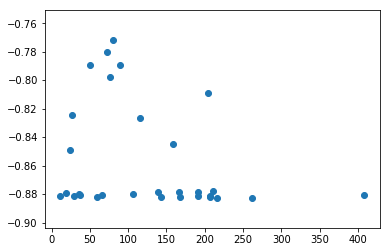

In [38]:
import matplotlib.pyplot
import pylab

y = [s for s, h in zip(scores, hyperparameters)]
x = [(h['dropout_relation'] +  h['dropout_text']) * h['hidden_size'] for h in hyperparameters]

matplotlib.pyplot.scatter(x,y)

matplotlib.pyplot.show()